In [268]:
import pandas as pd
import numpy as np

In [269]:
data = pd.read_csv("/home/tgraham/Documents/MSC/project_data/new_approach_data.csv",index_col=0)

In [270]:
data = data.drop(columns=["ActualCompletionDateTime","ExtractTimestamp","JobID","CentralAssetID"])

In [271]:
data = data.rename(columns={"prefix":"Region","ParameterValueID":"%Full","Previous_pvalue":"Previous_%Full"})

In [272]:
data.Region.unique()

array(['NW13', 'NW10', 'SW21', 'EA68', 'MD09', 'SE04', 'SO03', 'NE12'],
      dtype=object)

In [273]:
data["RouteID"] = data["RouteID"].astype(str)
data["Region"] = data["Region"].astype(str)
data["%Full"] = data["%Full"].astype(str)
data["Days_Since_Maintenance"] = data["Days_Since_Maintenance"].astype(int)

In [274]:
data["%Full"].unique()

array(['0-25', '2550', '7510', '5075', 'CLEA'], dtype=object)

In [275]:
data["Region"].value_counts()

SW21    141253
NW13    120936
NW10     75395
EA68     47733
SE04     24511
MD09      2117
NE12       938
SO03       177
Name: Region, dtype: int64

In [276]:
def edit_paramaterValueID (value):
    param_dict = {
        "CLEA":0,
        "0-25":1,
        "2550":2,
        "5075":3,
        "7510":4
    }
    return param_dict[value]

In [277]:
def encode_type_of_maintenance(value):
    if value == "Non-Emptying":
        return 0
    elif value == "Emptying":
        return 1
    else:
        pass

In [278]:
def encode_region(value):
    if value == 'SW21':
        return 1
    elif value == 'NW13':
        return 2
    elif value == 'NW10':
        return 3
    elif value == 'EA68':
        return 4
    elif value == 'SE04':
        return 5
    elif value == 'MD09':
        return 6
    elif value == 'NE12':
        return 7 
    elif value == 'SO03':
        return 8
    else:
        pass

In [1193]:
region_mapping = {1:"SW21",2:"NW13",3:"NW10",4:"EA68",5:"SE04",6:"MD09",7:"NE12",8:"SO03"}

In [279]:
data["%Full"] = data["%Full"].apply(edit_paramaterValueID)
data["Previous_%Full"] = data["Previous_%Full"].apply(edit_paramaterValueID)
data["Previous_type_of_maintenance"] = data["Previous_type_of_maintenance"].apply(encode_type_of_maintenance)
data["Region"] = data["Region"].apply(encode_region)

In [280]:
data = data.drop(columns="RouteID")

In [281]:
def reduce_cardinality_of_dsm(days):
    if days >= 0 and days <=90:
        return int(0)
    elif days > 90 and days <= 180:
        return int(1)
    elif days > 180 and days <= 270:
        return int(2)
    elif days > 270 and days <= 360:
        return int(3)
    elif days > 360 and days <= 450:
        return int(4)
    elif days > 450 and days <= 540:
        return int(5)
    elif days > 540 and days <= 630:
        return int(6)
    elif days > 630 and days < 720:
        return int(7)
    elif days >= 720:
        return int(8) 

In [1018]:
months_mapping = {0:"0-3",1:"4-6",2:"7-9",3:"10-12",4:"13-15",5:"16-18",6:"19-21",7:"22-24",8:">24"}

In [282]:
struct_data = data

In [283]:
struct_data["Months_Since_Maintenance"] = struct_data["Days_Since_Maintenance"].apply(reduce_cardinality_of_dsm)

In [284]:
struct_data["Months_Since_Maintenance"].value_counts()

2    91475
1    76611
3    72704
4    71057
0    41073
5    29521
6    12869
7     9770
8     7980
Name: Months_Since_Maintenance, dtype: int64

In [285]:
struct_data = struct_data.drop(columns="Days_Since_Maintenance")

In [286]:
struct_data = struct_data.drop(columns="FloodHotspot")

In [287]:
struct_data = struct_data.drop(columns="Failure_or_Maintenance")

In [1195]:
struct_data["Region"].unique()

array([2, 3, 1, 4, 6, 5, 8, 7])

# Modelling

# Gcastle

In [289]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict

import numpy as np
import networkx as nx

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM
from castle.common.priori_knowledge import PrioriKnowledge
import matplotlib.pyplot as plt

## PC

In [290]:
struct_data

%Full  Region  full_failure  covered_failure  broken_failure  \
15458       1       2             0                0               0   
15460       2       2             0                0               0   
15462       2       2             0                0               0   
15464       2       2             0                0               0   
15466       2       2             0                0               0   
...       ...     ...           ...              ...             ...   
551199      4       3             0                0               0   
551200      4       3             0                0               0   
551201      2       1             0                0               0   
551202      2       1             0                0               0   
551203      2       1             0                0               0   

        Previous_%Full  Previous_type_of_maintenance  Months_Since_Maintenance  
15458                1                             1                         0  
15460                2                             1                         0  
15462                2                             1                         0  
15464                2                             1                         0  
15466                2                             1                         0  
...                ...                           ...                       ...  
551199               2                             1                         2  
551200               2                             1                         2  
551201               3                             0                         2  
551202               3                             0                         2  
551203               2                             0                         2  

[413060 rows x 8 columns]

# For some weird reason the gCastle PC function is outputting bidirectional edges 1-3 3-1 , 1-5 5-1

In [475]:
# Build the model
pc_gcastle = PC(variant='stable',alpha=0.8) #,priori_knowledge=priori,alpha=0.8)
pc_gcastle.learn(struct_data)

In [476]:
print(pc_gcastle.causal_matrix)

[[0 0 0 0 0 0 1 0]
 [1 0 1 1 1 1 1 1]
 [1 0 0 0 1 0 0 1]
 [1 1 1 0 1 0 1 1]
 [0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 1 1]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0]]


In [293]:
learned_graph = nx.DiGraph(graph_object.causal_matrix)
print(learned_graph)

DiGraph with 8 nodes and 26 edges


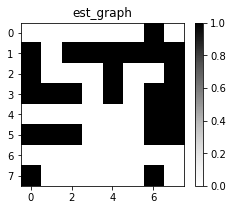

In [294]:
GraphDAG(pc.causal_matrix)

In [304]:
from causallearn.graph.Dag import Dag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.GraphNode import GraphNode
import networkx as nx


def create_dag_from_gcastle(graph_object,data,learned_graph):
    """
    This function takes a gcastle dag object and returns a causal learn graph so we can use the causal learn plotting function
    """
    
    try:
        # Convert it to a directioned dag
        learned_graph = nx.DiGraph(graph_object.causal_matrix)
    except:
        pass
    # Extract edges
    required_edges_indexes = list(learned_graph.edges)
    # Create mapping from indexes to namex
    MAPPING = {k: v for k, v in zip(range(len(data.columns)), list(data.columns.values))}
    # Apply mapping
    required_edges = []
    for item in required_edges_indexes:
        required_edges.append([MAPPING[item[0]],MAPPING[item[1]]])
    
    # Define DAG
    node_names = struct_data.columns
    nodes = []
    for name in node_names:
        node = GraphNode(name)
        nodes.append(node)
    dag = Dag(nodes)
    # Add edges
    for item in required_edges:
        #print(item)
        node1 = dag.get_node(item[0])
        node2 = dag.get_node(item[1])
        print(node1,node2)
        dag.add_directed_edge(node1, node2)
    #print(required_edges)
    return dag

In [305]:
learned_graph = nx.DiGraph(graph_object.causal_matrix)
print(learned_graph)
dag = create_dag_from_gcastle(pc,struct_data,learned_graph)

DiGraph with 8 nodes and 26 edges
%Full Previous_type_of_maintenance
Region %Full
Region full_failure
Region covered_failure
Region broken_failure
Region Previous_%Full
Region Previous_type_of_maintenance
Region Months_Since_Maintenance
full_failure %Full
full_failure broken_failure
full_failure Months_Since_Maintenance
covered_failure %Full
covered_failure Region
covered_failure full_failure
covered_failure broken_failure
covered_failure Previous_type_of_maintenance
covered_failure Months_Since_Maintenance
broken_failure Previous_type_of_maintenance
broken_failure Months_Since_Maintenance
Previous_%Full %Full
Previous_%Full Region
Previous_%Full full_failure
Previous_%Full Previous_type_of_maintenance
Previous_%Full Months_Since_Maintenance
Months_Since_Maintenance %Full
Months_Since_Maintenance Previous_type_of_maintenance


In [297]:
#dag.get_graph_edges()[0].get_node1().get_name(), dag.get_graph_edges()[0].get_node2().get_name()
for item in dag.get_graph_edges():
    print(item.get_node1().get_name(),item.get_node2().get_name())

Region %Full
full_failure %Full
covered_failure %Full
Previous_%Full %Full
%Full Previous_type_of_maintenance
Months_Since_Maintenance %Full
Region full_failure
covered_failure Region
Region broken_failure
Previous_%Full Region
Region Previous_type_of_maintenance
Region Months_Since_Maintenance
covered_failure full_failure
full_failure broken_failure
Previous_%Full full_failure
full_failure Months_Since_Maintenance
covered_failure broken_failure
covered_failure Previous_type_of_maintenance
covered_failure Months_Since_Maintenance
broken_failure Previous_type_of_maintenance
broken_failure Months_Since_Maintenance
Previous_%Full Previous_type_of_maintenance
Previous_%Full Months_Since_Maintenance
Months_Since_Maintenance Previous_type_of_maintenance


In [298]:
data = struct_data 
graph_object = pc

In [299]:
# Convert it to a directioned dag
learned_graph = nx.DiGraph(graph_object.causal_matrix)

# Extract edges
required_edges_indexes = list(learned_graph.edges)
# Create mapping from indexes to namex
MAPPING = {k: v for k, v in zip(range(len(data.columns)), list(data.columns.values))}
# Apply mapping
required_edges = []
for item in required_edges_indexes:
    required_edges.append([MAPPING[item[0]],MAPPING[item[1]]])

In [300]:
required_edges_indexes

[(0, 6),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 4),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 6),
 (3, 7),
 (4, 6),
 (4, 7),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 6),
 (5, 7),
 (7, 0),
 (7, 6)]

In [301]:
# Define DAG
node_names = struct_data.columns
nodes = []
for name in node_names:
    node = GraphNode(name)
    nodes.append(node)
dag = Dag(nodes)
print(dag.get_graph_edges())
# Add edges
for item in required_edges:
    #print(item)
    node1 = dag.get_node(item[0])
    node2 = dag.get_node(item[1])
    print(node1,node2)
    dag.add_directed_edge(node1, node2)

[]
%Full Previous_type_of_maintenance
Region %Full
Region full_failure
Region covered_failure
Region broken_failure
Region Previous_%Full
Region Previous_type_of_maintenance
Region Months_Since_Maintenance
full_failure %Full
full_failure broken_failure
full_failure Months_Since_Maintenance
covered_failure %Full
covered_failure Region
covered_failure full_failure
covered_failure broken_failure
covered_failure Previous_type_of_maintenance
covered_failure Months_Since_Maintenance
broken_failure Previous_type_of_maintenance
broken_failure Months_Since_Maintenance
Previous_%Full %Full
Previous_%Full Region
Previous_%Full full_failure
Previous_%Full Previous_type_of_maintenance
Previous_%Full Months_Since_Maintenance
Months_Since_Maintenance %Full
Months_Since_Maintenance Previous_type_of_maintenance


In [302]:
#dag.get_graph_edges()[0].get_node1().get_name(), dag.get_graph_edges()[0].get_node2().get_name()
for item in dag.get_graph_edges():
    print(item.get_node1().get_name(),item.get_node2().get_name())

Region %Full
full_failure %Full
covered_failure %Full
Previous_%Full %Full
%Full Previous_type_of_maintenance
Months_Since_Maintenance %Full
Region full_failure
covered_failure Region
Region broken_failure
Previous_%Full Region
Region Previous_type_of_maintenance
Region Months_Since_Maintenance
covered_failure full_failure
full_failure broken_failure
Previous_%Full full_failure
full_failure Months_Since_Maintenance
covered_failure broken_failure
covered_failure Previous_type_of_maintenance
covered_failure Months_Since_Maintenance
broken_failure Previous_type_of_maintenance
broken_failure Months_Since_Maintenance
Previous_%Full Previous_type_of_maintenance
Previous_%Full Months_Since_Maintenance
Months_Since_Maintenance Previous_type_of_maintenance


In [392]:
struct_data

%Full  Region  full_failure  covered_failure  broken_failure  \
15458       1       2             0                0               0   
15460       2       2             0                0               0   
15462       2       2             0                0               0   
15464       2       2             0                0               0   
15466       2       2             0                0               0   
...       ...     ...           ...              ...             ...   
551199      4       3             0                0               0   
551200      4       3             0                0               0   
551201      2       1             0                0               0   
551202      2       1             0                0               0   
551203      2       1             0                0               0   

        Previous_%Full  Previous_type_of_maintenance  Months_Since_Maintenance  
15458                1                             1                         0  
15460                2                             1                         0  
15462                2                             1                         0  
15464                2                             1                         0  
15466                2                             1                         0  
...                ...                           ...                       ...  
551199               2                             1                         2  
551200               2                             1                         2  
551201               3                             0                         2  
551202               3                             0                         2  
551203               2                             0                         2  

[413060 rows x 8 columns]

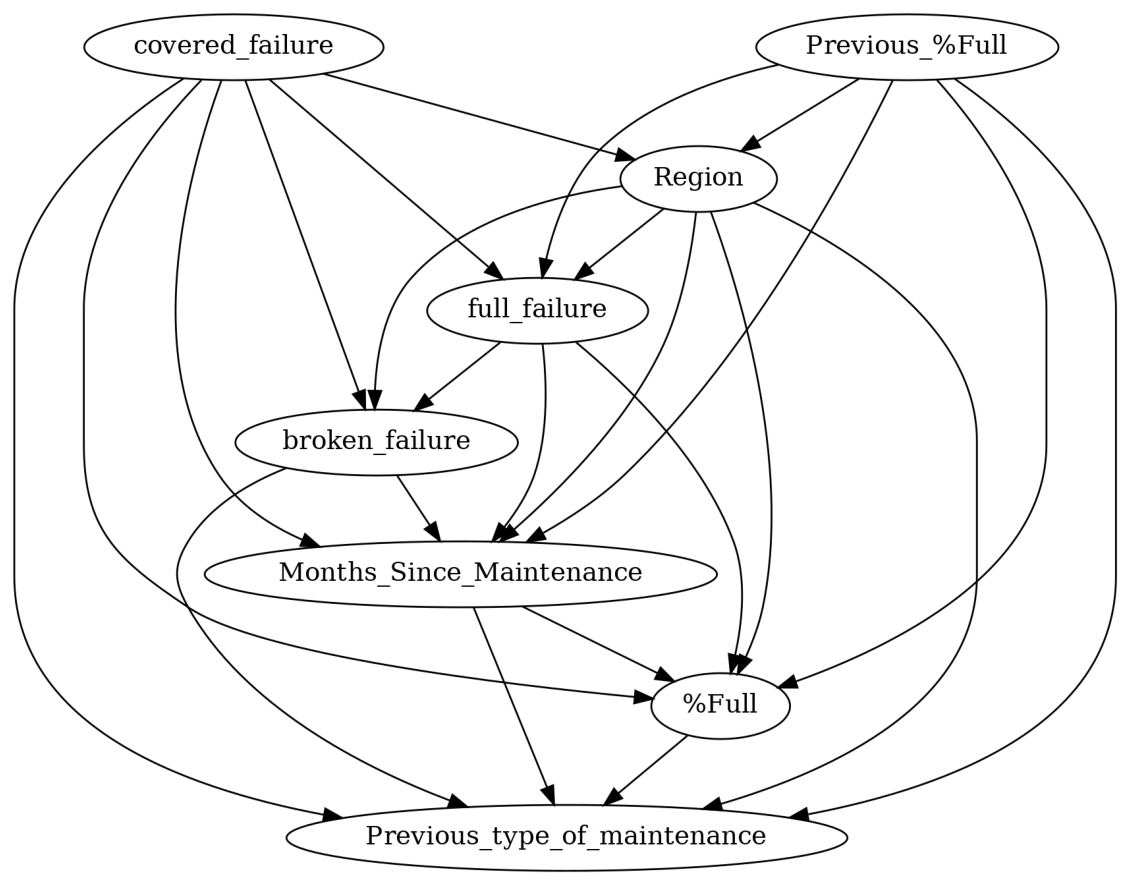

In [303]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

## GES

In [786]:
from castle.algorithms import GES

# DirectLiNGAM learn
ges = GES()
ges.learn(struct_data)

SyntaxError: invalid syntax (4024011601.py, line 1)

In [536]:
ges.causal_matrix

Tensor([[0, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0]])

## LINGAM

In [322]:
from castle.algorithms import DirectLiNGAM

# DirectLiNGAM learn
lingam_gcastle = DirectLiNGAM()
lingam_gcastle.learn(struct_data)

/home/tgraham/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/tgraham/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScale

In [323]:
learned_graph = nx.DiGraph(lingam_gcastle.causal_matrix)

In [310]:
LINGNAM_dag = create_dag_from_gcastle(lingam_gcastle,struct_data,learned_graph)

full_failure %Full
full_failure Region
full_failure covered_failure
full_failure Previous_%Full
full_failure Months_Since_Maintenance
covered_failure Region
covered_failure Months_Since_Maintenance
broken_failure Region
broken_failure Months_Since_Maintenance
Previous_type_of_maintenance Region
Previous_type_of_maintenance Previous_%Full


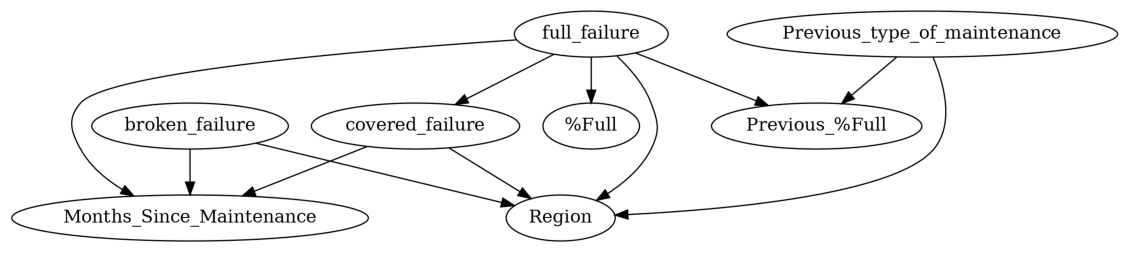

In [311]:
pyd = GraphUtils.to_pydot(LINGNAM_dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

## GOLEM

In [101]:
from castle.algorithms import GOLEM

# DirectLiNGAM learn
#golem = GOLEM()
#golem.learn(struct_data)

# Took too long

## DAG-GNN Graph Neural Network

In [102]:
from castle.algorithms import DAG_GNN


#gnn = DAG_GNN()
#gnn.learn(data=struct_data)
# Took Too long

# CausalLearn Package

In [316]:
struct_data

%Full  Region  full_failure  covered_failure  broken_failure  \
15458       1       2             0                0               0   
15460       2       2             0                0               0   
15462       2       2             0                0               0   
15464       2       2             0                0               0   
15466       2       2             0                0               0   
...       ...     ...           ...              ...             ...   
551199      4       3             0                0               0   
551200      4       3             0                0               0   
551201      2       1             0                0               0   
551202      2       1             0                0               0   
551203      2       1             0                0               0   

        Previous_%Full  Previous_type_of_maintenance  Months_Since_Maintenance  
15458                1                             1                         0  
15460                2                             1                         0  
15462                2                             1                         0  
15464                2                             1                         0  
15466                2                             1                         0  
...                ...                           ...                       ...  
551199               2                             1                         2  
551200               2                             1                         2  
551201               3                             0                         2  
551202               3                             0                         2  
551203               2                             0                         2  

[413060 rows x 8 columns]

## GES

In [343]:
from causallearn.search.ScoreBased.GES import ges
score_func = "local_score_BDeu"
ges_causallearn = ges(struct_data, score_func)

[[ 0  1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  1]
 [ 1  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  

In [318]:
print(f"Bdeu score: {ges_causallearn['score']}")

Bdeu score: 2574553.1892441297


In [180]:
struct_data

%Full  Region  full_failure  covered_failure  broken_failure  \
15458       1       2             0                0               0   
15460       2       2             0                0               0   
15462       2       2             0                0               0   
15464       2       2             0                0               0   
15466       2       2             0                0               0   
...       ...     ...           ...              ...             ...   
551199      4       3             0                0               0   
551200      4       3             0                0               0   
551201      2       1             0                0               0   
551202      2       1             0                0               0   
551203      2       1             0                0               0   

        Previous_%Full  Previous_type_of_maintenance  Months_Since_Maintenance  
15458                1                             1                         0  
15460                2                             1                         0  
15462                2                             1                         0  
15464                2                             1                         0  
15466                2                             1                         0  
...                ...                           ...                       ...  
551199               2                             1                         2  
551200               2                             1                         2  
551201               3                             0                         2  
551202               3                             0                         2  
551203               2                             0                         2  

[413060 rows x 8 columns]

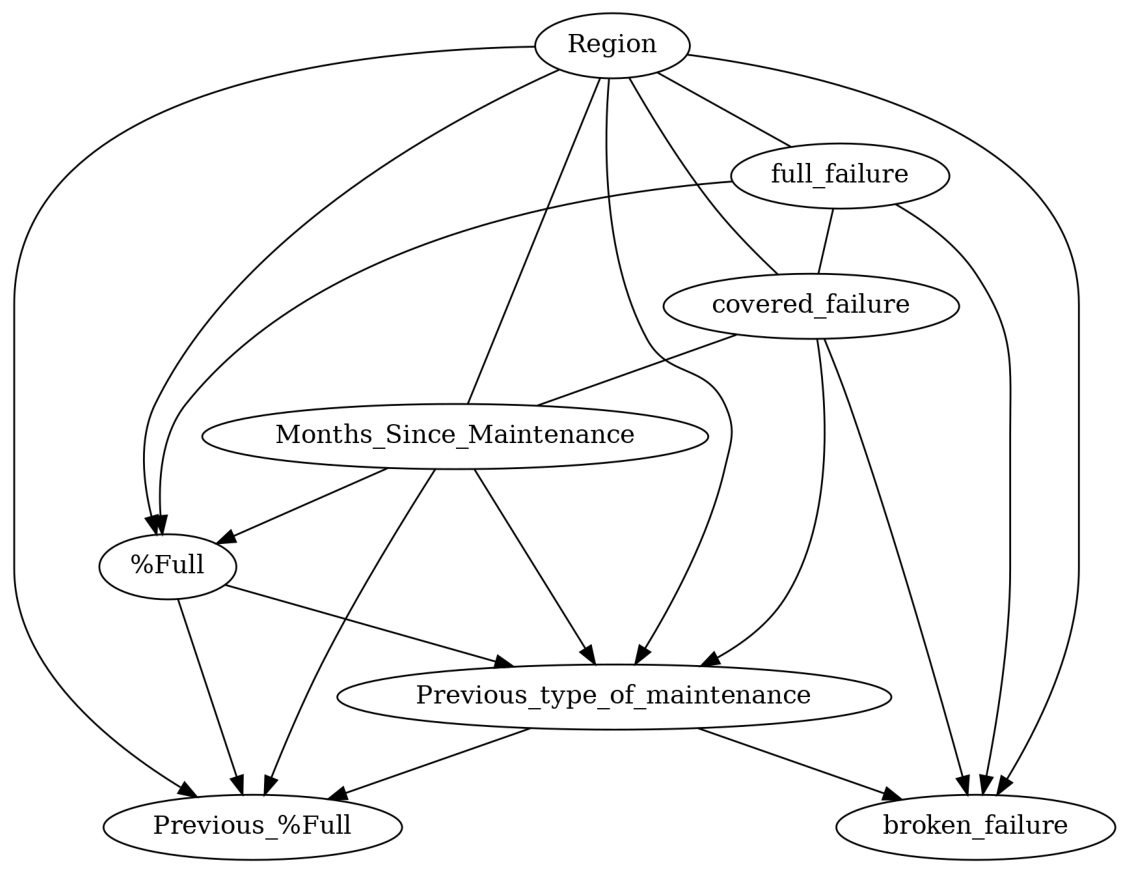

In [181]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(ges_causallearn['G'],labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()


# or save the graph
pyd.write_png('GES_algorithm.png')

## PC-Stable

In [326]:
from causallearn.search.ConstraintBased.PC import pc

In [327]:
struct_array = struct_data.to_numpy()

In [484]:
pc_causallearn = pc(struct_array, alpha=0.8,stable=True, indep_test = "fisherz",verbose= False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [485]:
print(pc_causallearn.G)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8

Graph Edges:
1. X2 --> X1
2. X1 --- X3
3. X4 --> X1
4. X6 --> X1
5. X1 --> X7
6. X1 --- X8
7. X2 --> X3
8. X2 --- X4
9. X2 --> X5
10. X2 --- X6
11. X2 --> X7
12. X2 --> X8
13. X4 --> X3
14. X3 --> X5
15. X6 --> X3
16. X3 --- X8
17. X4 --> X5
18. X4 --> X7
19. X4 --> X8
20. X5 --> X7
21. X8 --> X5
22. X6 --> X7
23. X6 --> X8
24. X8 --> X7



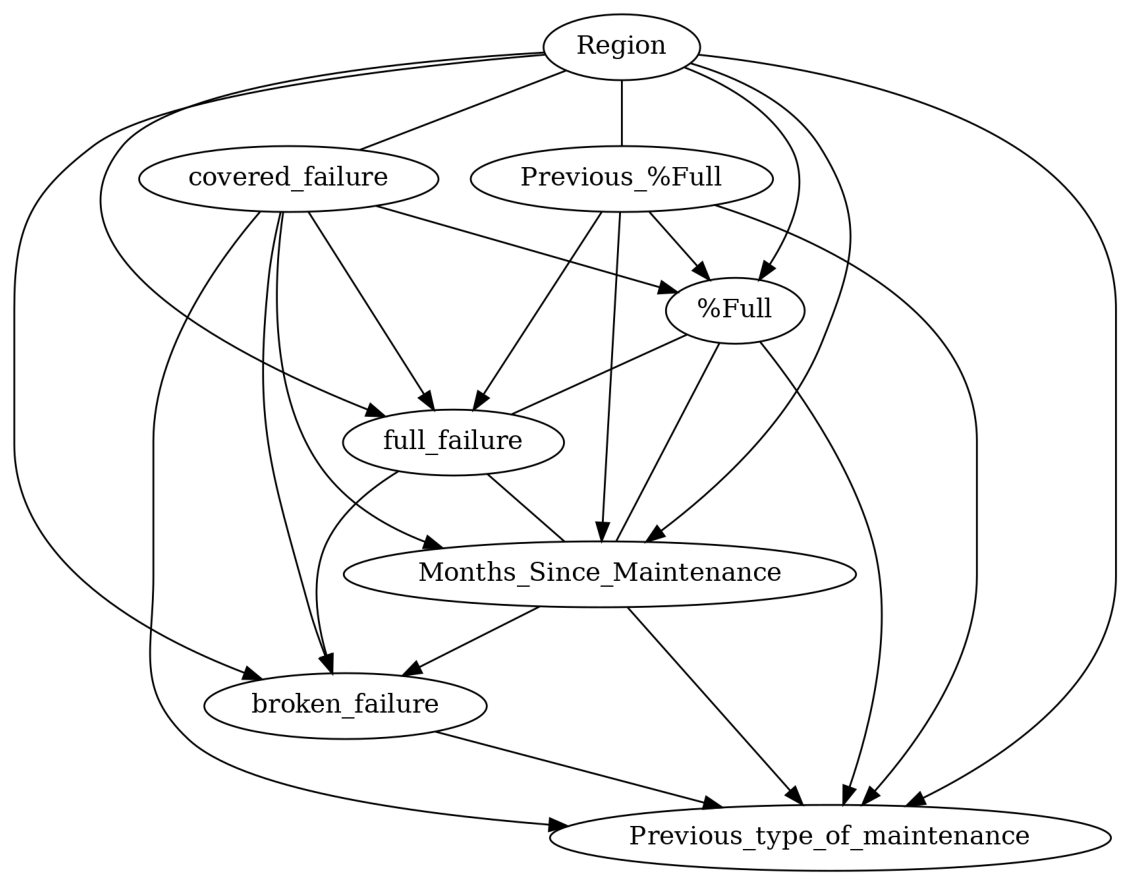

In [486]:
from matplotlib.pyplot import figure
# visualization using pydot
pyd = GraphUtils.to_pydot(pc_causallearn.G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()
pyd.write_png('PC.png')

## FCI 

In [491]:
from causallearn.search.ConstraintBased.FCI import fci

In [492]:
struct_array = struct_data.to_numpy()

In [493]:
fci_causallearn, edges = fci(struct_array, alpha=0.8, indep_test = "fisherz",verbose= False)

  0%|          | 0/8 [00:00<?, ?it/s]

X4 --> X1
X1 --> X7
X3 --> X5
X4 --> X7
X5 --> X7
X8 --> X5


In [494]:
struct_data.columns

Index(['%Full', 'Region', 'full_failure', 'covered_failure', 'broken_failure',
       'Previous_%Full', 'Previous_type_of_maintenance',
       'Months_Since_Maintenance'],
      dtype='object')

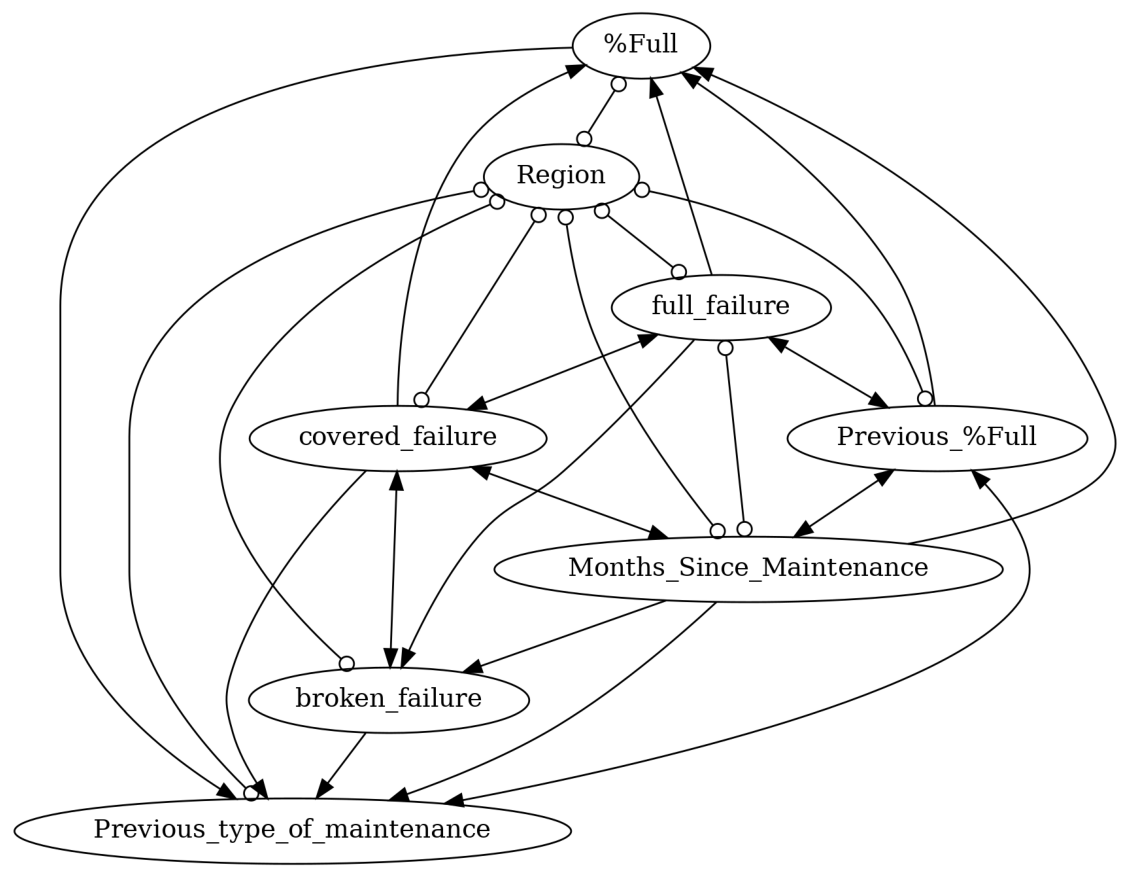

In [495]:
pyd = GraphUtils.to_pydot(fci_causallearn,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('FCI.png')

## GRaSP 

In [336]:
from causallearn.search.PermutationBased.GRaSP import grasp
score_func="local_score_BDeu"
# or customized parameters
grasp_causallearn = grasp(struct_array, score_func)

GRaSP edge count: 19    
GRaSP completed in: 118.79s 


In [337]:
grasp_edges = G.get_graph_edges()

In [152]:
for edge in grasp_edges:
    print([edge.get_node1().name,edge.get_numerical_endpoint1(),edge.get_node2().name,edge.get_numerical_endpoint2()])

['x0', -1, 'x1', -1]
['x0', -1, 'x2', -1]
['x0', -1, 'x5', -1]
['x0', -1, 'x6', -1]
['x0', -1, 'x7', -1]
['x1', -1, 'x2', -1]
['x1', -1, 'x3', 1]
['x1', -1, 'x4', 1]
['x1', -1, 'x5', -1]
['x1', -1, 'x6', -1]
['x1', -1, 'x7', -1]
['x2', -1, 'x3', 1]
['x2', -1, 'x4', 1]
['x2', -1, 'x7', -1]
['x3', -1, 'x4', 1]
['x6', -1, 'x3', 1]
['x7', -1, 'x3', 1]
['x6', -1, 'x4', 1]
['x5', -1, 'x6', -1]
['x5', -1, 'x7', -1]
['x6', -1, 'x7', -1]


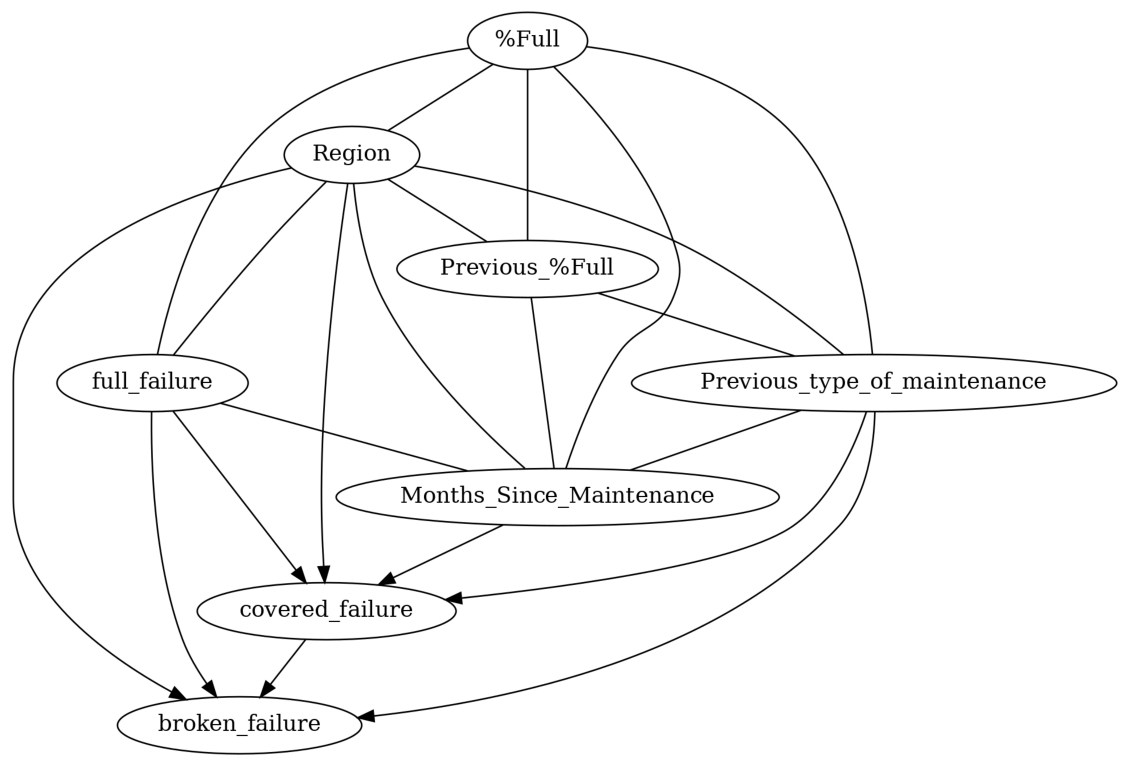

In [145]:
pyd = GraphUtils.to_pydot(G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()
pyd.write_png('GRASP.png')

# Bnlearn

## HillClimbSearch

In [540]:
# Load library
import bnlearn as bn
# Load example
# Structure learning
hill_climb_bdeu_bnlearn = bn.structure_learning.fit(struct_data, methodtype='hc', scoretype='bdeu')
# Compute edge strength using chi-square independence test and remove (prune) the not-signficant edges
model1 = bn.independence_test(hill_climb_bdeu_bnlearn, struct_data, alpha=0.05, prune=False)
# Examine the output of the chi-square test. All P values are significant. Nothing is removed.
#    source     target     stat_test        p_value    chi_square    dof
#--  ---------  ---------  -----------  -----------  ------------  -----
# 0  Cloudy     Rain       True         1.08061e-87       394.062      1
# 1  Cloudy     Sprinkler  True         8.38371e-53       233.906      1
# 2  Rain       Wet_Grass  True         3.88651e-64       285.902      1
# 3  Sprinkler  Wet_Grass  True         1.19692e-23       100.478      1

# Plot
# Compute edge strength using chi-square independence test and remove (prune) the not-signficant edges
model3 = bn.independence_test(hill_climb_bdeu_bnlearn, struct_data, alpha=0.05, prune=True)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bdeu]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Compute edge strength with [chi_square]


In [542]:
hill_climb_bdeu_bnlearn["adjmat"]

target                        %Full  Region  full_failure  covered_failure  \
source                                                                       
%Full                         False    True          True            False   
Region                        False   False          True             True   
full_failure                  False   False         False             True   
covered_failure               False   False         False            False   
broken_failure                False   False         False            False   
Previous_%Full                False    True         False            False   
Previous_type_of_maintenance  False    True         False             True   
Months_Since_Maintenance      False    True          True             True   

target                        broken_failure  Previous_%Full  \
source                                                         
%Full                                  False            True   
Region                                  True           False   
full_failure                            True           False   
covered_failure                         True           False   
broken_failure                         False           False   
Previous_%Full                         False           False   
Previous_type_of_maintenance            True           False   
Months_Since_Maintenance               False           False   

target                        Previous_type_of_maintenance  \
source                                                       
%Full                                                 True   
Region                                               False   
full_failure                                         False   
covered_failure                                      False   
broken_failure                                       False   
Previous_%Full                                        True   
Previous_type_of_maintenance                         False   
Months_Since_Maintenance                             False   

target                        Months_Since_Maintenance  
source                                                  
%Full                                             True  
Region                                           False  
full_failure                                     False  
covered_failure                                  False  
broken_failure                                   False  
Previous_%Full                                    True  
Previous_type_of_maintenance                      True  
Months_Since_Maintenance                         False

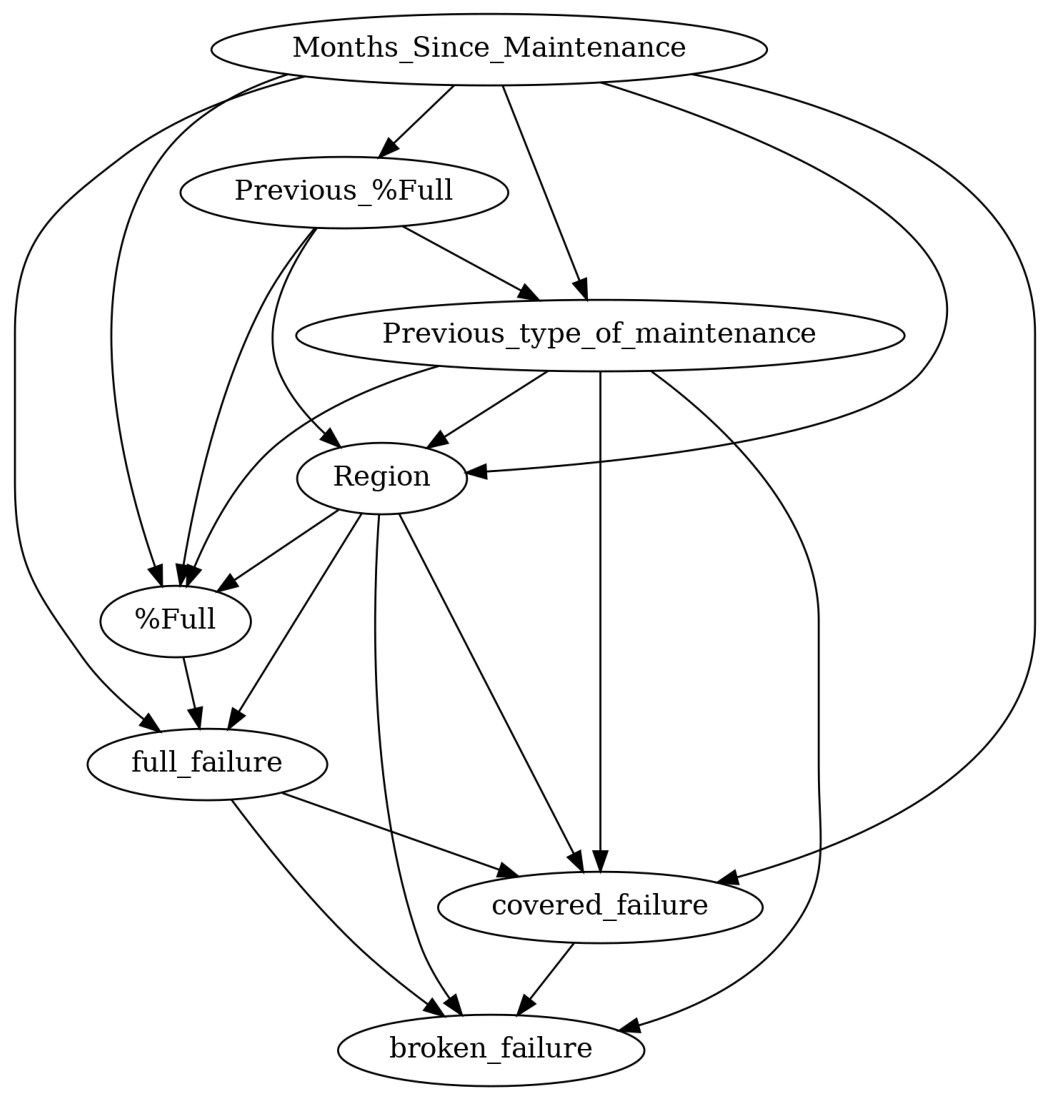

In [809]:
node_names = struct_data.columns
nodes = []
for name in node_names:
    node = GraphNode(name)
    nodes.append(node)
dag = Dag(nodes)

for item in model3["model_edges"]:
    node1 = dag.get_node(item[0])
    node2 = dag.get_node(item[1])
    dag.add_directed_edge(node1, node2)
# visualization using pydot
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('HillClimb.png')

# Use Background Knowledge

### GCastle Background Knowledge code for reference below

In [81]:
#priori = PrioriKnowledge(struct_data.shape[1])
#priori.add_forbidden_edges(output)
#pc = PC(variant='stable',priori_knowledge=priori,alpha=0.8)

In [744]:
mapped = {}
for index, item in enumerate(struct_data.columns):
    mapped[item]=index
forbidden_edges = [("%Full", "Previous_%Full"),
                    ("Months_Since_Maintenance","Previous_%Full"),
                    ("%Full","Region"),
                    ("Previous_%Full", "Region"),
                    ("broken_failure","Region"),
                    ("covered_failure","Region"),
                    ("full_failure","Region"),
                    ("full_failure","Months_Since_Maintenance"),
                    ("covered_failure","Months_Since_Maintenance"),
                    ("broken_failure","Months_Since_Maintenance"),
                    ("full_failure","Previous_%Full"),
                    ("covered_failure","Previous_%Full"),
                    ("broken_failure","Previous_%Full"),
                    ("full_failure","Previous_type_of_maintenance"),
                    ("covered_failure","Previous_type_of_maintenance"),
                    ("broken_failure","Previous_type_of_maintenance")]
output = []
for item in forbidden_edges:
    output.append((mapped[item[0]],mapped[item[1]]))

In [745]:
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphClass import CausalGraph
cg = CausalGraph(8)
nodes = cg.G.get_nodes()

In [746]:
bk = BackgroundKnowledge()
for item in output:
    bk.add_forbidden_by_node(nodes[item[0]], nodes[item[1]])

In [737]:
struct_array = struct_data.to_numpy()

## PC - Background knowledge

In [957]:
pc_background_causallearn = pc(struct_array,alpha=0.8, indep_test = "fisherz",verbose= False, background_knowledge=bk)

  0%|          | 0/8 [00:00<?, ?it/s]

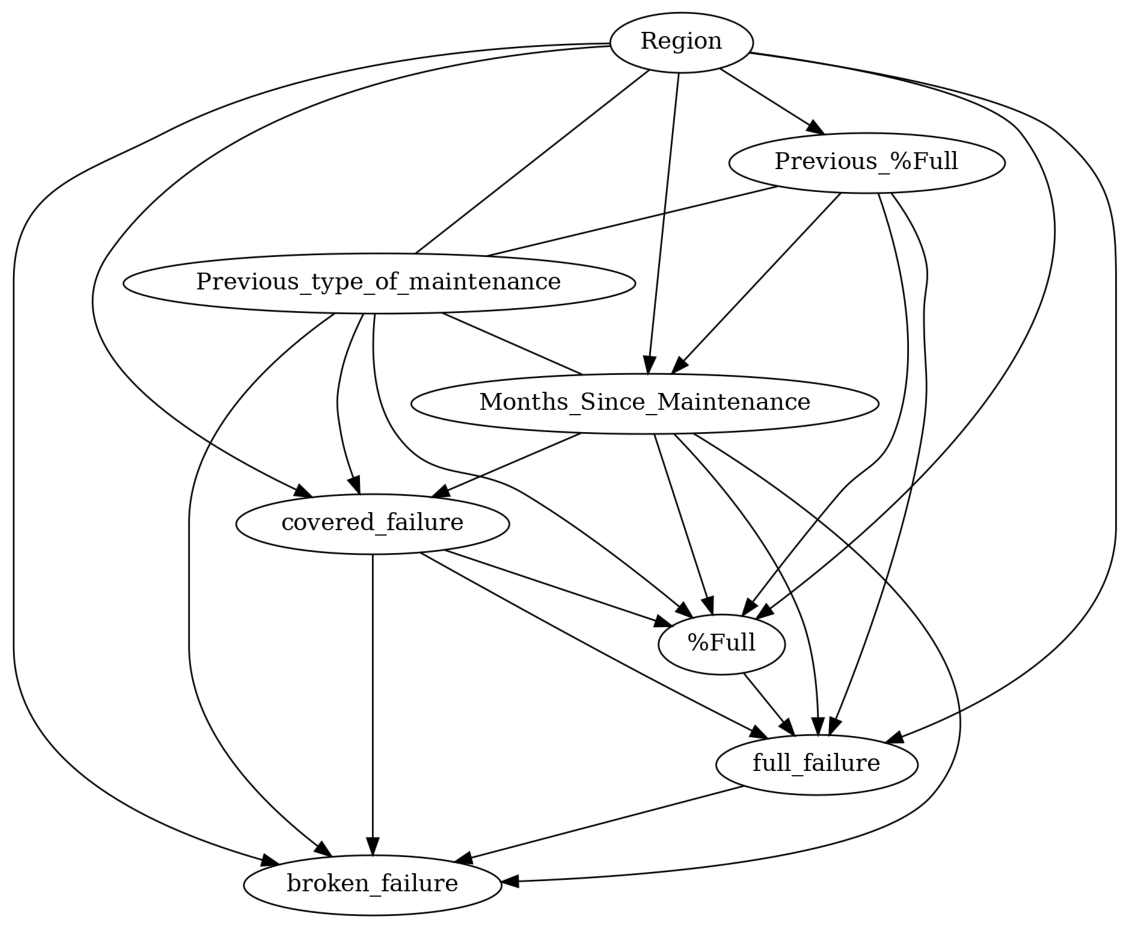

In [958]:
# visualization using pydot
pyd = GraphUtils.to_pydot(pc_background_causallearn.G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()


pyd.write_png('PC_Background_Knowledge.png')

## FCI - Background Knowledge

In [742]:
fci_background_causallearn, edges = fci(struct_array, alpha=0.05, indep_test = "fisherz",verbose= False,background_knowledge=bk)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X2 --> X1
Orienting edge (Knowledge): X6 --> X1
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X4
Orienting edge (Knowledge): X2 --> X5
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X6 --> X3
Orienting edge (Knowledge): X8 --> X3
Orienting edge (Knowledge): X7 --> X4
Orienting edge (Knowledge): X8 --> X4
Orienting edge (Knowledge): X7 --> X5
Orienting edge (Knowledge): X8 --> X5
Orienting edge (Knowledge): X6 --> X8
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X2 --> X1
Orienting edge (Knowledge): X6 --> X1
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X4
Orienting edge (Knowledge): X2 --> X5
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X6 --> X3
Orienting edge (Knowledge): X8 --> X3
Orienting edge (Knowledge): X7 --> X4
Orienting edge (Knowledge): X8 --> X4
Orienting edge (Knowledge): X7 --> X5
Orienting ed

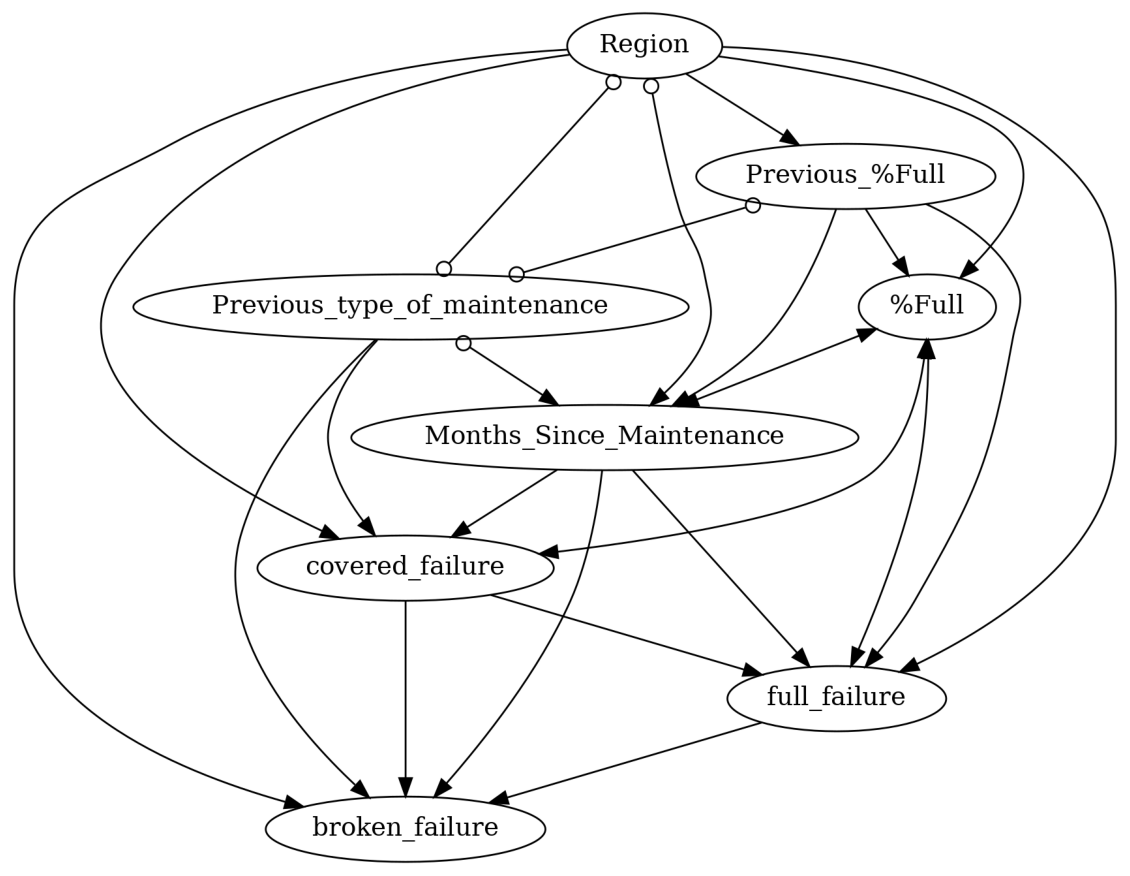

In [747]:
# visualization using pydot
pyd = GraphUtils.to_pydot(fci_background_causallearn,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()


pyd.write_png('simple_test.png')

# Functions to convert Causal Learn dags into gcastle tensor objects - This enables comparison between DAGs

In [ ]:
def create_broken_down_edges(dag):
    """
    Takes a causallearn data object and outputs the edges and edge types 
    Input: causallearn graph dag
    output: list of lists of tupes [[(Node1,type_of_connection1)),(Node2,type_of_connection2)],]
    """
    # Get Edges
    edges = dag.get_graph_edges()
    
    # Break edges down into node 1 and node 2
    broken_down_edges = []
    for edge in edges:
        broken_down_edges.append([(edge.get_node1().name,edge.get_numerical_endpoint1()),(edge.get_node2().name,edge.get_numerical_endpoint2())])
    
    return broken_down_edges

In [410]:
def create_mapping(dag,struct_data):
    # Create Mapping dict
    mapping = {}
    try:
        if isinstance(dag.get_node_names()[0],str) == True:
            for i, c in enumerate(dag.get_node_names()):
                mapping[c] = i
        else:
            for i, c in enumerate(struct_data):
                mapping[c] = i
    except:
        for i, c in enumerate(struct_data):
                mapping[c] = i
    return mapping

In [508]:
from castle.common import Tensor
def create_matrix_from_edge_list(struct_data,broken_down_edges,mapping):
    """
    The PC implemented in GCastle and the PC implemented in causallearn is different and should be treated differently. The same goes for hill climb. 
    In th Gcastle version of PC there are no -1 values. In the causallearn version there are, this may be due to different implementation. I will use the CausalLearn one. 
    When it comes to the hill climb algorithm, it outputs a DAG meaning there is no need to have the -1 values and this will create an even DAG and everything will add up to 0.
    I need to add an exception to this.
    All Algorithms that output just DAG's need to have only the outbound edges active.
    """
    # Create 2d list 
    positions = [[0 for j in range(len(list(mapping.keys())))] for i in range(len(list(mapping.keys())))]
    # Iterate through edges and apply the correct links to the tensor
    for index, column in enumerate(list(mapping.keys())):
        # find all outband edges 
        for item in broken_down_edges:
            if item[0][0] == column:
                y = mapping[item[0][0]]
                x = mapping[item[1][0]]
                positions[y][x] = item[1][1]
        # find all inbound edges
        for item in broken_down_edges:
            if item[1][0] == column:
                y = mapping[item[0][0]]
                x = mapping[item[1][0]]
                positions[x][y] = item[0][1]
        
    #turn the list into array
    m = np.asarray(positions)
    output = Tensor(m)
    return output

In [203]:
dag = truth_dag

In [749]:
broken_down_edges = create_broken_down_edges(dag)
mapping = create_mapping(dag,struct_data)
output_truth_matrix = create_matrix_from_edge_list(struct_data,broken_down_edges,mapping)

In [750]:
output_truth_matrix

Tensor([[ 0, -1,  1,  1,  0, -1, -1, -1],
        [ 1,  0,  1,  1,  1,  1,  1,  1],
        [-1, -1,  0,  0,  0, -1, -1, -1],
        [-1, -1,  0,  0,  1,  0, -1, -1],
        [ 0, -1,  0, -1,  0,  0,  0, -1],
        [ 1, -1,  1,  0,  0,  0, -1,  1],
        [ 1, -1,  1,  1,  0,  1,  0,  1],
        [ 1, -1,  1,  1,  1, -1, -1,  0]])

# Create Manually Classified Truth DAG

In [644]:
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphClass import CausalGraph
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import orient_by_background_knowledge
cg = CausalGraph(9)
nodes = cg.G.get_nodes()

In [645]:
from causallearn.graph.Dag import Dag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.GraphNode import GraphNode

mapped = {}
for index, item in enumerate(struct_data.columns):
    mapped[item]=index
required_edges = [("Region","Months_Since_Maintenance"),
                  ("Region","full_failure"),
                  ("Region","covered_failure"),
                  ("Region","Previous_%Full"),
                  ("Region","broken_failure"),
                  ("Region","%Full"),
                  ("Region","Previous_type_of_maintenance"),
                  ("Months_Since_Maintenance","full_failure"),
                  ("Months_Since_Maintenance","covered_failure"),
                  ("Months_Since_Maintenance","broken_failure"),
                  ("Months_Since_Maintenance","%Full"),
                  ("Previous_%Full","%Full"),
                  ("Previous_%Full","full_failure"),
                  ("Previous_%Full","Months_Since_Maintenance"),
                  ("%Full","full_failure"),
                  ("%Full","covered_failure"),
                  ("Previous_type_of_maintenance","Previous_%Full"),
                  ("Previous_type_of_maintenance","full_failure"),
                  ("Previous_type_of_maintenance","covered_failure"),
                  ("Previous_type_of_maintenance","%Full"),
                  ("Previous_type_of_maintenance","Months_Since_Maintenance"),
                  ("covered_failure","broken_failure")]
output = []
for item in required_edges:
    output.append((mapped[item[0]],mapped[item[1]]))
    
    
node_names = struct_data.columns
nodes = []
for name in node_names:
    node = GraphNode(name)
    nodes.append(node)
dag = Dag(nodes)

for item in required_edges:
    node1 = dag.get_node(item[0])
    node2 = dag.get_node(item[1])
    dag.add_directed_edge(node1, node2)

In [646]:
truth_dag = dag

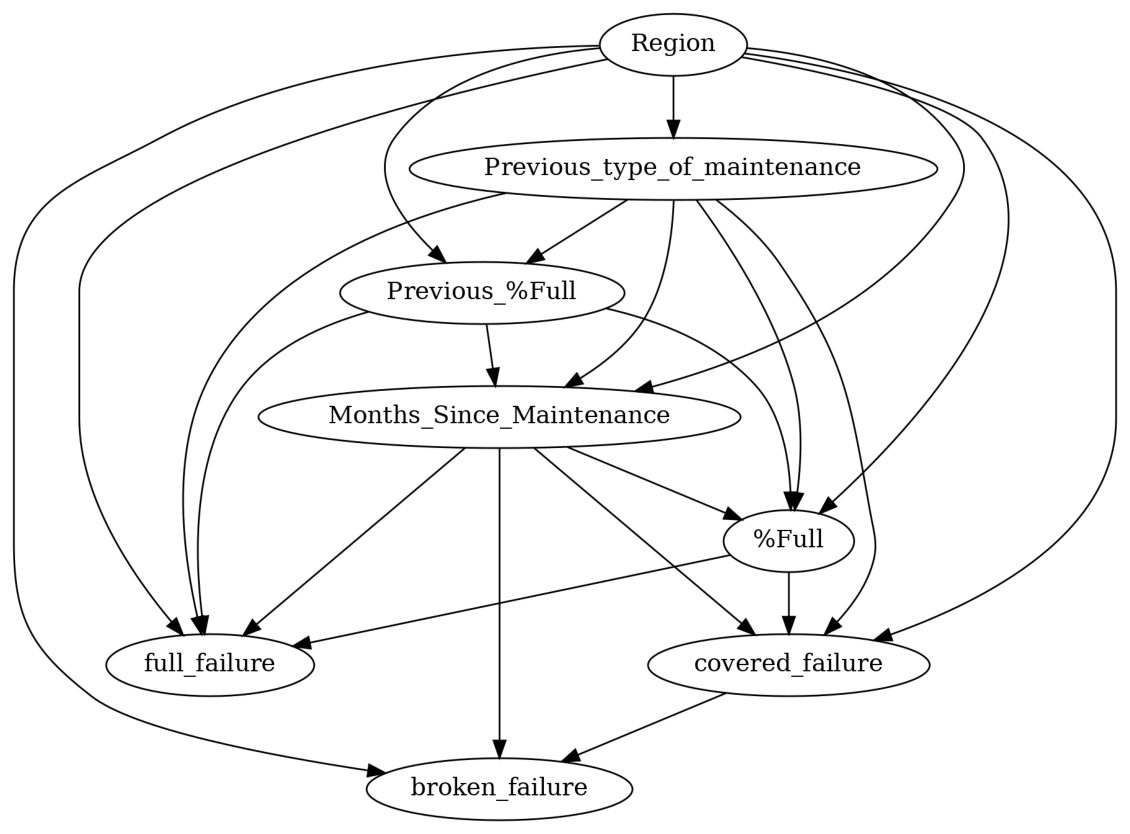

In [523]:
# visualization using pydot
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('human_intuition.png')

In [524]:
broken_down_edges = create_broken_down_edges(dag)
mapping = create_mapping(dag,struct_data)
output_truth_matrix = create_matrix_from_edge_list(struct_data,broken_down_edges,mapping)

In [525]:
output_truth_matrix

Tensor([[ 0, -1,  1,  1,  0, -1, -1, -1],
        [ 1,  0,  1,  1,  1,  1,  1,  1],
        [-1, -1,  0,  0,  0, -1, -1, -1],
        [-1, -1,  0,  0,  1,  0, -1, -1],
        [ 0, -1,  0, -1,  0,  0,  0, -1],
        [ 1, -1,  1,  0,  0,  0, -1,  1],
        [ 1, -1,  1,  1,  0,  1,  0,  1],
        [ 1, -1,  1,  1,  1, -1, -1,  0]])

# Comparing all causal diagrams and plotting the results

In [938]:
all_graphs_no_background = {'gcastle_lingam':lingam_gcastle,'causallearn_ges':ges_causallearn,'causallearn_pc':pc_causallearn,'causallearn_fci':fci_causallearn,'causallearn_grasp':grasp_causallearn,'bnlearn_hill_climb':hill_climb_bdeu_bnlearn,'causallearn_pc_background':pc_background_causallearn,'causallearn_fci_background':fci_background_causallearn}

In [939]:
output_matrices = {"algorithm":[],"matrix":[]}
for key,value in zip(all_graphs_no_background.keys(),all_graphs_no_background.values()):
    if key.find('causallearn')!= -1:
        print(key)
        if key.find('causallearn_ges')!= -1:
            broken_down_edges = create_broken_down_edges(value['G'])
            mapping = create_mapping(value['G'],struct_data)
            output_matrix = create_matrix_from_edge_list(struct_data,broken_down_edges,mapping)
            output_matrices["algorithm"].append(key)
            output_matrices["matrix"].append(output_matrix)
        elif key.find('causallearn_pc')!= -1:
            broken_down_edges = create_broken_down_edges(value.G)
            mapping = create_mapping(value.G,struct_data)
            output_matrix = create_matrix_from_edge_list(struct_data,broken_down_edges,mapping)
            output_matrices["algorithm"].append(key)
            output_matrices["matrix"].append(output_matrix)
        else:
            broken_down_edges = create_broken_down_edges(value)
            mapping = create_mapping(value,struct_data)
            output_matrix = create_matrix_from_edge_list(struct_data,broken_down_edges,mapping)
            output_matrices["algorithm"].append(key)
            output_matrices["matrix"].append(output_matrix)
    elif key.find("gcastle") != -1:
        print(key)
        output_matrix = value.causal_matrix
        output_matrices["algorithm"].append(key)
        output_matrices["matrix"].append(output_matrix)
    else:
        print(key)
        mapping = create_mapping(value,struct_data)
        broken_down_edges = []
        for item in value["model_edges"]:
            broken_down_edges.append([(item[0],-1),(item[1],1)])
        output_matrix = create_matrix_from_edge_list(struct_data,broken_down_edges,mapping)
        output_matrices["algorithm"].append(key)
        output_matrices["matrix"].append(output_matrix)

gcastle_lingam
causallearn_ges
causallearn_pc
causallearn_fci
causallearn_grasp
bnlearn_hill_climb
causallearn_pc_background
causallearn_fci_background


In [953]:
def compute_metrics(truth_matrix,matrix):
    finished_edges = []
    shd=0
    edges=0
    accurate_matches=0
    innacurate_matches=0
    fp = 0
    fn = 0
    tp = 0
    tn = 0          
    for index_y,item_y in enumerate(matrix):
        for index_x,node_x in enumerate(item_y):
            if str(index_x) + str(index_y) in finished_edges:
                pass
            else:
                finished_edges.append(str(index_y)+str(index_x))
                edge_test = (node_x,matrix[index_x][index_y])
                edge_truth = (truth_matrix[index_y][index_x],truth_matrix[index_x][index_y])
                # If complete match - no edge = no edge
                if edge_truth[0] == 0 and edge_truth[1]==0 and edge_test[0] == 0 and edge_test[1]==0:
                    shd+=0
                    tn+=1
                    accurate_matches+=1 
                else:
                    # Matching edge shd+=0
                    if (edge_test[0] == edge_truth[0]) & (edge_test[1] == edge_truth[1]):
                        shd+=0
                        edges+=1
                        accurate_matches+=1 
                        tp+= 1
                    elif edge_test[0] != 0 or edge_test[1] !=0:
                        # If true edge A->B and learnt edge A<-B, A-B, A<->B - shd+=0.5
                        # If true edge B->A and learnt edge B<-A, A-B, A<->B - shd+=0.5
                        if edge_truth[0] != 0 or edge_truth[1] != 0:
                            shd+=0.5
                            edges+=1
                            innacurate_matches +=0.5
                            fp+=0.5
                            fn+=0.5
                        # False Positive - No match 
                        elif edge_truth[0] == 0 and edge_truth[1]==0:
                            fp+=1
                            innacurate_matches +=1
                            shd+=1
                            edges+=1
                    # No edge in test edge in truth 
                    elif edge_test[0] == 0 and edge_test[1] == 0:
                        if edge_truth[0] != 0 or edge_truth[1] != 0:
                            shd+=1
                            innacurate_matches += 1
                            fn+=1
                        else: 
                            print("here")

    accuracy = accurate_matches/(accurate_matches+innacurate_matches)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F1 = tp/(tp+0.5*(fp+fn))
    output_dict = {}
    output_dict["shd"] = shd
    output_dict["edges"] = edges
    output_dict["accuracy"] = accuracy 
    output_dict["precision"] = precision
    output_dict["recall"] = recall
    output_dict["F1"]= F1
    i = ((len(matrix)*(len(matrix)-1))/2) - edges
    output_dict["bsf"] = 0.5*((tp/edges)+ (tn/i) - (fp/i) - (fn/edges))
    #print(f'tp:{tp},tn:{tn},fp:{fp},fn:{fn}')
    return output_dict 

In [954]:
count = 0
output_dict = {'algorithm':[],'shd': [], 'edges': [], 'accuracy': [], 'precision': [], 'recall': [], 'F1': [],'bsf':[]}
for algo,matrix in zip(output_matrices["algorithm"],output_matrices["matrix"]):
    output = compute_metrics(output_truth_matrix,matrix)
    output['algorithm'] = algo
    for item in output.keys():
        output_dict[item].append(output[item])

In [955]:
data = pd.DataFrame(output_dict)

In [956]:
data

algorithm   shd  edges  accuracy  precision    recall  \
0              gcastle_lingam  18.0     11  0.419355   0.000000  0.000000   
1             causallearn_ges  13.0     20  0.580645   0.466667  0.411765   
2              causallearn_pc   9.5     24  0.688525   0.540541  0.606061   
3             causallearn_fci  13.0     24  0.518519   0.200000  0.230769   
4           causallearn_grasp  13.0     19  0.566667   0.384615  0.312500   
5          bnlearn_hill_climb  11.0     21  0.656250   0.588235  0.555556   
6   causallearn_pc_background   7.0     23  0.794118   0.761905  0.800000   
7  causallearn_fci_background   8.5     23  0.738462   0.666667  0.702703   

         F1       bsf  
0  0.000000 -0.566845  
1  0.437500  0.112500  
2  0.571429  0.385417  
3  0.214286 -0.270833  
4  0.344828  0.064327  
5  0.571429  0.333333  
6  0.780488  0.860870  
7  0.684211  0.613043

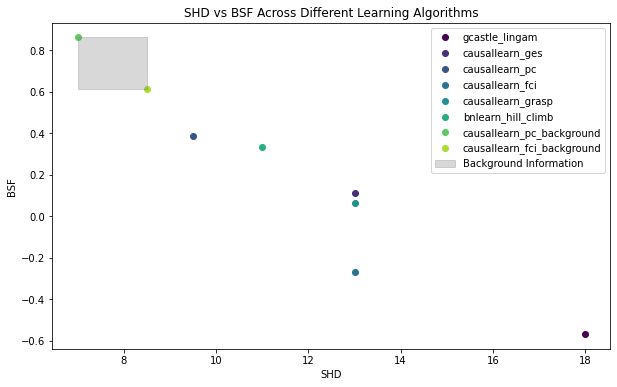

In [944]:
import matplotlib.pyplot as plt
import numpy as np

x = data["shd"]
y = data["bsf"]
plt.figure(figsize=(10, 6))

# Create the scatter plot with different colors for each point
for i, algorithm in zip(range(len(x)),data["algorithm"]):
    plt.scatter(x[i], y[i], color=plt.cm.viridis(i / len(x)), label=algorithm)


# Define the shaded regions
x_shade = [data[data["algorithm"].str.find("background")!=-1]["shd"].min(),data[data["algorithm"].str.find("background")!=-1]["shd"].max()]
y_upper = data[data["algorithm"].str.find("background")!=-1]["bsf"].max()
y_lower = data[data["algorithm"].str.find("background")!=-1]["bsf"].min()

# Fill the shaded regions
plt.fill_between(x_shade, y_lower, y_upper, color='gray', alpha=0.3, label='Background Information')

# Add labels and title
plt.xlabel('SHD')
plt.ylabel('BSF')
plt.title('SHD vs BSF Across Different Learning Algorithms')
plt.legend()

# Show the ploto
plt.show()

# Learn Parameters using the bnlearn Parameter Learning functionality 

### Convert a Causal Learn DAG to a bnlearn DAG

In [849]:
dag = pc_background_causallearn.G

In [850]:
list(struct_data.columns)

['%Full',
 'Region',
 'full_failure',
 'covered_failure',
 'broken_failure',
 'Previous_%Full',
 'Previous_type_of_maintenance',
 'Months_Since_Maintenance']

In [851]:
mapping = {'X1':'%Full',
 'X2':'Region',
 'X3':'full_failure',
 'X4':'covered_failure',
 'X5':'broken_failure',
 'X6':'Previous_%Full',
 'X7':'Previous_type_of_maintenance',
 'X8':'Months_Since_Maintenance'}
# The below code extracts the edges from a dag so that a bnlearn dag structure can be  created
edges = []
for edge in dag.get_graph_edges():
    edges.append((mapping[edge.get_node1().get_name()],mapping[edge.get_node2().get_name()]))


In [853]:
edges

[('Region', '%Full'),
 ('%Full', 'full_failure'),
 ('covered_failure', '%Full'),
 ('Previous_%Full', '%Full'),
 ('Previous_type_of_maintenance', '%Full'),
 ('Months_Since_Maintenance', '%Full'),
 ('Region', 'full_failure'),
 ('Region', 'covered_failure'),
 ('Region', 'broken_failure'),
 ('Region', 'Previous_%Full'),
 ('Region', 'Previous_type_of_maintenance'),
 ('Region', 'Months_Since_Maintenance'),
 ('covered_failure', 'full_failure'),
 ('full_failure', 'broken_failure'),
 ('Previous_%Full', 'full_failure'),
 ('Months_Since_Maintenance', 'full_failure'),
 ('covered_failure', 'broken_failure'),
 ('Previous_type_of_maintenance', 'covered_failure'),
 ('Months_Since_Maintenance', 'covered_failure'),
 ('Previous_type_of_maintenance', 'broken_failure'),
 ('Months_Since_Maintenance', 'broken_failure'),
 ('Previous_%Full', 'Previous_type_of_maintenance'),
 ('Previous_%Full', 'Months_Since_Maintenance'),
 ('Previous_type_of_maintenance', 'Months_Since_Maintenance')]

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


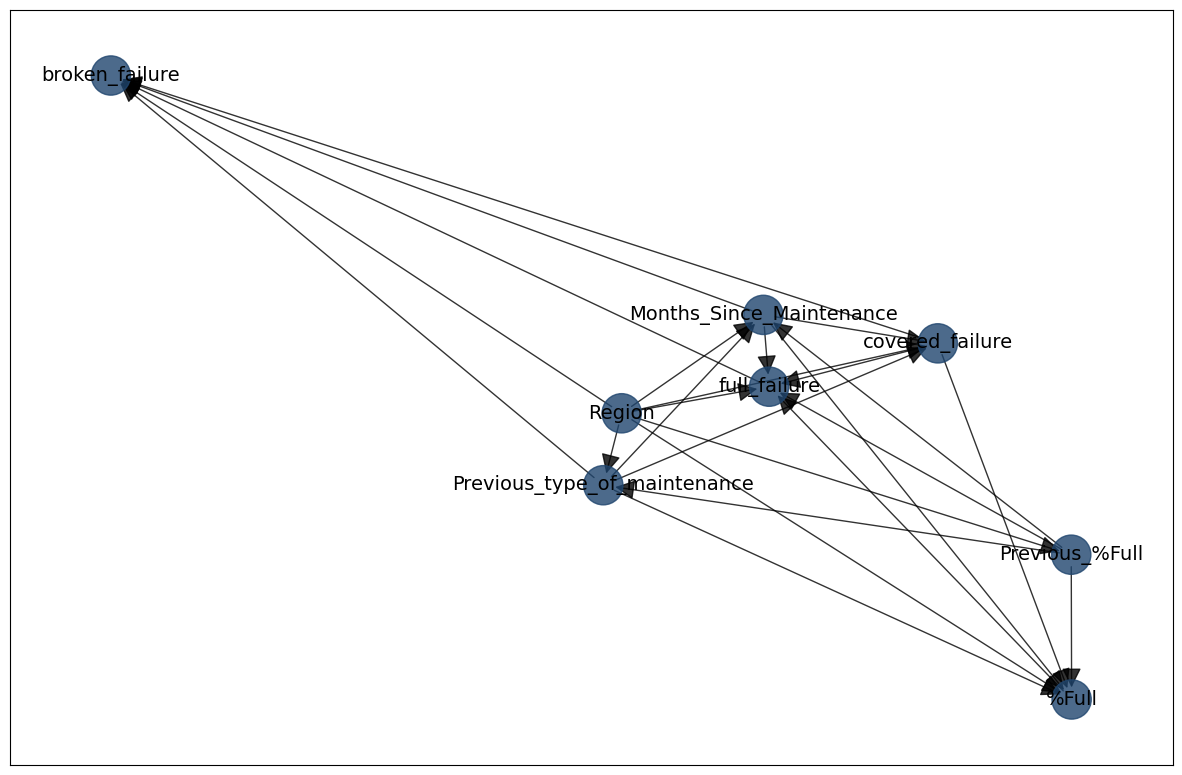

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Region:
+-----------+-------------+
| Region(1) | 0.341443    |
+-----------+-------------+
| Region(2) | 0.292376    |
+-----------+-------------+
| Region(3) | 0.182389    |
+-----------+-------------+
| Region(4) | 0.115582    |
+-----------+-------------+
| Region(5) | 0.0594986   |
+-----------+-------------+
| Region(6) | 0.00541467  |
+-----------+-------------+
| Region(7) | 0.00256726  |
+-----------+-------------+
| Region(8) | 0.000729363 |
+-----------+-------------+
[bnlearn] >CPD of %Full:
+------------------------------+-----+---------------------------------+
| Months_Since_Maintenance     | ... | Months_Since_Maintenance(8)     |
+------------------------------+-----+---------------------------------+
| Previous_%Full               | ... | Previous_%Full(4)               |
+------------------------------+-----+---------------------------------+
| Previous_type_of_maintenance | ... | Pre

In [855]:
#edges = [('A', 'B'), ('A', 'C'), ('A', 'D')]
# Create DAG and store in model
model = bn.make_DAG(edges)
bn.plot(model)
DAG_update = bn.parameter_learning.fit(model, struct_data)

In [891]:
struct_data["Region"].value_counts()

1    141253
2    120936
3     75395
4     47733
5     24511
6      2117
7       938
8       177
Name: Region, dtype: int64

# Intervention Analysis

### Does the time to maintenance effect failure rates?

In [1019]:
months_mapping = {0:"0-3",1:"4-6",2:"7-9",3:"10-12",4:"13-15",5:"16-18",6:"19-21",7:"22-24",8:">24"}

In [1035]:
df[df["broken_failure"]==1]["p"][1]

0.006927506851435119

In [1126]:
output_dict = {"Months":[],"Probability_of_broken_failure":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[]}
for i in range(0,9):
    q1 = bn.inference.fit(DAG_update, variables=['broken_failure'], evidence={"Months_Since_Maintenance":i})
    df1 = q1.df
    output_dict["Probability_of_broken_failure"].append(df1[df1["broken_failure"]==1]["p"][1])

    q2 = bn.inference.fit(DAG_update, variables=['full_failure'], evidence={"Months_Since_Maintenance":i})
    df2 = q2.df
    output_dict["Probability_of_full_failure"].append(df2[df2["full_failure"]==1]["p"][1])

    q3 = bn.inference.fit(DAG_update, variables=['covered_failure'], evidence={"Months_Since_Maintenance":i})
    df3 = q3.df
    output_dict["Probability_of_covered_failure"].append(df3[df3["covered_failure"]==1]["p"][1])
    
    output_dict["Months"].append(months_mapping[i])

[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.993072   |
+----+------------------+------------+
|  1 |                1 | 0.00692751 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.992316   |
+----+----------------+------------+
|  1 |              1 | 0.00768424 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.985005 |
+----+-------------------+----------+
|  1 |                 1 | 0.014995 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.997623   |
+----+------------------+------------+
|  1 |                1 | 0.00237673 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997855   |
+----+----------------+------------+
|  1 |              1 | 0.00214466 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.994271   |
+----+-------------------+------------+
|  1 |                 1 | 0.00572919 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998315   |
+----+------------------+------------+
|  1 |                1 | 0.00168509 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.99834    |
+----+----------------+------------+
|  1 |              1 | 0.00165973 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996063   |
+----+-------------------+------------+
|  1 |                 1 | 0.00393679 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998439   |
+----+------------------+------------+
|  1 |                1 | 0.00156074 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.99861    |
+----+----------------+------------+
|  1 |              1 | 0.00138956 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.997589   |
+----+-------------------+------------+
|  1 |                 1 | 0.00241098 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998686   |
+----+------------------+------------+
|  1 |                1 | 0.00131352 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998829   |
+----+----------------+------------+
|  1 |              1 | 0.00117147 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.997828  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0021717 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.997274   |
+----+------------------+------------+
|  1 |                1 | 0.00272635 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.9975     |
+----+----------------+------------+
|  1 |              1 | 0.00250003 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996067   |
+----+-------------------+------------+
|  1 |                 1 | 0.00393342 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.994799   |
+----+------------------+------------+
|  1 |                1 | 0.00520149 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.994985   |
+----+----------------+------------+
|  1 |              1 | 0.00501489 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.993409   |
+----+-------------------+------------+
|  1 |                 1 | 0.00659128 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.993017   |
+----+------------------+------------+
|  1 |                1 | 0.00698336 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.991387  |
+----+----------------+-----------+
|  1 |              1 | 0.0086133 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.989317  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0106826 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.992006  |
+----+------------------+-----------+
|  1 |                1 | 0.0079944 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.992581   |
+----+----------------+------------+
|  1 |              1 | 0.00741859 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.992021   |
+----+-------------------+------------+
|  1 |                 1 | 0.00797858 |
+----+-------------------+------------+


In [1127]:
output = pd.DataFrame(output_dict)

Text(0.5, 1.0, 'Plot of Probability of Failure vs Time for the three Failure Modes')

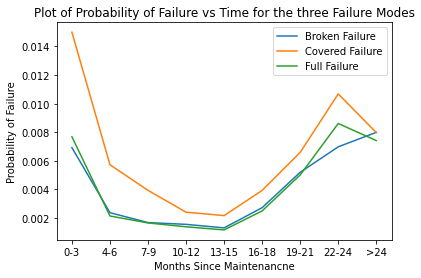

In [1146]:
plt.plot(output["Months"],output["Probability_of_broken_failure"],label='Broken Failure')
plt.plot(output["Months"],output["Probability_of_covered_failure"],label='Covered Failure')
plt.plot(output["Months"],output["Probability_of_full_failure"],label='Full Failure')
plt.legend()
plt.xlabel("Months Since Maintenancne")
plt.ylabel("Probability of Failure")
plt.title("Plot of Probability of Failure vs Time for the three Failure Modes")

In [1133]:
output[output["Months"].isin(["0-3","4-6","7-9","10-12"])]["Probability_of_full_failure"].sum()

0.012878187540901666

In [1142]:
one_year = ["0-3","4-6","7-9","10-12"]
two_years = ["0-3","4-6","7-9","10-12","13-15","16-18","19-21","22-24"]
full_failure_within_one_year = output[output["Months"].isin(one_year)]["Probability_of_full_failure"].sum()
covered_failure_within_one_year = output[output["Months"].isin(one_year)]["Probability_of_covered_failure"].sum()
full_failure_within_two_years = output[output["Months"].isin(two_years)]["Probability_of_full_failure"].sum() 
covered_failure_within_two_years = output[output["Months"].isin(two_years)]["Probability_of_covered_failure"].sum()

In [1140]:
failure_within_one_year_broken = output[output["Months"].isin(one_year)]["Probability_of_broken_failure"].sum()
failure_within_two_years_broken = output[output["Months"].isin(two_years)]["Probability_of_broken_failure"].sum()

In [1145]:
print(f"Probability of at least one full failure within one year: {full_failure_within_one_year}")
print(f"Probability of at least one covered failure within one year: {covered_failure_within_one_year}")
print(f"Probability of at least one broken failure within one year: {failure_within_one_year_broken}")

Probability of at least one full failure within one year: 0.012878187540901666
Probability of at least one covered failure within one year: 0.02707195532633378
Probability of at least one broken failure within one year: 0.012550072996960863


In [1149]:
full_failure_within_one_year+covered_failure_within_one_year+failure_within_one_year_broken

0.05250021586419631

In [1147]:
print(f"Probability of at least one full failure within two years: {full_failure_within_two_years}")
print(f"Probability of at least one covered failure within two years: {covered_failure_within_two_years}")
print(f"Probability of at least one broken failure within two years: {failure_within_two_years_broken}")

Probability of at least one full failure within two years: 0.03017788088769928
Probability of at least one covered failure within two years: 0.050450912645276604
Probability of at least one broken failure within two years: 0.028774789413441384


In [1148]:
full_failure_within_two_years+covered_failure_within_two_years+failure_within_two_years_broken

0.10940358294641728

### Is previous percentage full predictive of future percentage full?

In [1111]:
output_dict = {"Previous_%Full":[],"%Full_Predicted":[],"Probability_of_%Full":[]}
for i in range(0,5):
    q1 = bn.inference.fit(DAG_update, variables=['%Full'], evidence={"Previous_%Full":i})
    df1 = q1.df
    for index, row in df1.iterrows():
        output_dict["Probability_of_%Full"].append(row["p"])
        output_dict["Previous_%Full"].append(i)
        output_dict["%Full_Predicted"].append(row["%Full"])

[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0862014 |
+----+---------+-----------+
|  1 |       1 | 0.354969  |
+----+---------+-----------+
|  2 |       2 | 0.335088  |
+----+---------+-----------+
|  3 |       3 | 0.114527  |
+----+---------+-----------+
|  4 |       4 | 0.109215  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+----------+
|    |   %Full |        p |
+====+=========+==========+
|  0 |       0 | 0.071749 |
+----+---------+----------+
|  1 |       1 | 0.321378 |
+----+---------+----------+
|  2 |       2 | 0.309567 |
+----+---------+----------+
|  3 |       3 | 0.168883 |
+----+---------+----------+
|  4 |       4 | 0.128424 |
+----+---------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0604765 |
+----+---------+-----------+
|  1 |       1 | 0.262396  |
+----+---------+-----------+
|  2 |       2 | 0.351378  |
+----+---------+-----------+
|  3 |       3 | 0.221553  |
+----+---------+-----------+
|  4 |       4 | 0.104197  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0461896 |
+----+---------+-----------+
|  1 |       1 | 0.221268  |
+----+---------+-----------+
|  2 |       2 | 0.351571  |
+----+---------+-----------+
|  3 |       3 | 0.255884  |
+----+---------+-----------+
|  4 |       4 | 0.125088  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0451775 |
+----+---------+-----------+
|  1 |       1 | 0.261816  |
+----+---------+-----------+
|  2 |       2 | 0.31668   |
+----+---------+-----------+
|  3 |       3 | 0.208043  |
+----+---------+-----------+
|  4 |       4 | 0.168284  |
+----+---------+-----------+


In [1120]:
data = pd.DataFrame(output_dict)

In [1121]:
data["%Full_Predicted"] = data["%Full_Predicted"].astype(int)

In [1322]:
param_dict = {
        0:"0%",
        1:"0-25%",
        2:"25-50%",
        3:"50-75%",
        4:"75-100%"
    }
data["Previous_%Full"] = data["Previous_%Full"].apply(lambda x: param_dict[x])

KeyError: ''

In [1123]:
data["%Full_Predicted"] = data["%Full_Predicted"].apply(lambda x: param_dict[x])

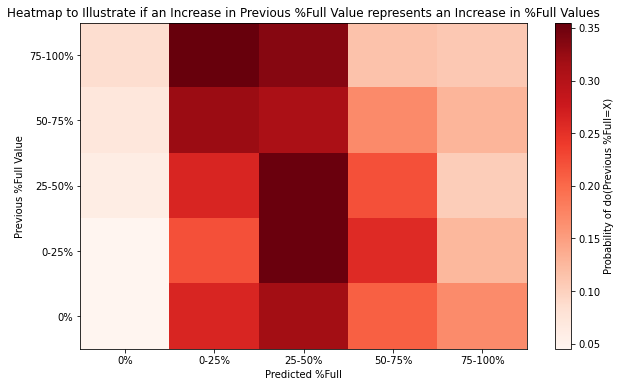

In [1124]:
# Pivot the DataFrame to prepare for heatmap
heatmap_data = data.pivot(index='Previous_%Full', columns='%Full_Predicted', values='Probability_of_%Full')

# Create the heatmap
plt.figure(figsize=(10, 6))  # Set the figure size
plt.imshow(heatmap_data, cmap='Reds', interpolation='nearest', aspect='auto')

# Add a colorbar to indicate the probability values
plt.colorbar(label='Probability of do(Previous %Full=X)')

# Set the x and y tick labels
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index[::-1])  # Reverse the True Label axis

# Add labels and title
plt.xlabel('Predicted %Full')
plt.ylabel('Previous %Full Value')
plt.title('Heatmap to Illustrate if an Increase in Previous %Full Value represents an Increase in %Full Values')

# Show the plot
plt.show()

### Does previous percentage full influence covered and full failures?

In [1156]:
output_dict = {"Previous_%Full":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[]}
for i in range(0,5):
    q1 = bn.inference.fit(DAG_update, variables=['full_failure'], evidence={"Previous_%Full":i})
    df1 = q1.df
    output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
    output_dict["Previous_%Full"].append(i)
    q2 = bn.inference.fit(DAG_update, variables=['covered_failure'], evidence={"Previous_%Full":i})
    df2 = q2.df
    output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.994493   |
+----+----------------+------------+
|  1 |              1 | 0.00550748 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.989904  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0100956 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.997895  |
+----+----------------+-----------+
|  1 |              1 | 0.0021054 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.994693   |
+----+-------------------+------------+
|  1 |                 1 | 0.00530689 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998054   |
+----+----------------+------------+
|  1 |              1 | 0.00194609 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.995446   |
+----+-------------------+------------+
|  1 |                 1 | 0.00455447 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.99793    |
+----+----------------+------------+
|  1 |              1 | 0.00207027 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996567   |
+----+-------------------+------------+
|  1 |                 1 | 0.00343271 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.99486    |
+----+----------------+------------+
|  1 |              1 | 0.00514006 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.993938   |
+----+-------------------+------------+
|  1 |                 1 | 0.00606212 |
+----+-------------------+------------+


In [1159]:
data = pd.DataFrame(output_dict)

In [1161]:
data["Previous_%Full"] = data["Previous_%Full"].apply(lambda x: param_dict[x])

Text(0.5, 1.0, 'Plot of Probability of Failure vs Previous Percentage Full for two Failure Modes')

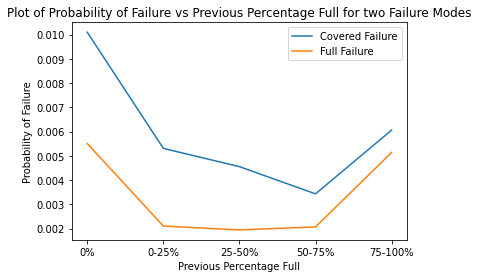

In [1168]:
plt.plot(data["Previous_%Full"],data["Probability_of_covered_failure"],label='Covered Failure')
plt.plot(data["Previous_%Full"],data["Probability_of_full_failure"],label='Full Failure')
plt.legend()
plt.xlabel("Previous Percentage Full")
plt.ylabel("Probability of Failure")
plt.title("Plot of Probability of Failure vs Previous Percentage Full for two Failure Modes")

### Does the type of maintenance effect the probability of failure?

In [1178]:
output_dict = {"Previous_type_of_maintenance":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[],"Probability_of_broken_failure":[]}
for i in range(0,2):
    q1 = bn.inference.fit(DAG_update, variables=['full_failure'], evidence={"Previous_type_of_maintenance":i})
    df1 = q1.df
    output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
    output_dict["Previous_type_of_maintenance"].append(i)
    
    q2 = bn.inference.fit(DAG_update, variables=['covered_failure'], evidence={"Previous_type_of_maintenance":i})
    df2 = q2.df
    output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])
    
    q2 = bn.inference.fit(DAG_update, variables=['broken_failure'], evidence={"Previous_type_of_maintenance":i})
    df2 = q2.df
    output_dict["Probability_of_broken_failure"].append(df2[df2["broken_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.988437 |
+----+----------------+----------+
|  1 |              1 | 0.011563 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.975727  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0242728 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.984082  |
+----+------------------+-----------+
|  1 |                1 | 0.0159184 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998022   |
+----+----------------+------------+
|  1 |              1 | 0.00197834 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996349   |
+----+-------------------+------------+
|  1 |                 1 | 0.00365091 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998332   |
+----+------------------+------------+
|  1 |                1 | 0.00166823 |
+----+------------------+------------+


In [1179]:
output_dict

{'Previous_type_of_maintenance': [0, 1],
 'Probability_of_full_failure': [0.011562975447170028, 0.001978344055285621],
 'Probability_of_covered_failure': [0.024272832056410596,
  0.0036509067458563253],
 'Probability_of_broken_failure': [0.01591844014021608, 0.0016682269615302151]}

In [1180]:
data = pd.DataFrame(output_dict)

In [1181]:
data

Previous_type_of_maintenance  Probability_of_full_failure  \
0                             0                     0.011563   
1                             1                     0.001978   

   Probability_of_covered_failure  Probability_of_broken_failure  
0                        0.024273                       0.015918  
1                        0.003651                       0.001668

In [1182]:
maintenance_mapping = {0:"Non-Emptying",1:"Emptying"}

In [1183]:
data["Previous_type_of_maintenance"] = data["Previous_type_of_maintenance"].apply(lambda x: maintenance_mapping[x])

In [1184]:
data

Previous_type_of_maintenance  Probability_of_full_failure  \
0                 Non-Emptying                     0.011563   
1                     Emptying                     0.001978   

   Probability_of_covered_failure  Probability_of_broken_failure  
0                        0.024273                       0.015918  
1                        0.003651                       0.001668

This may be skewed due to most regions only doing emptying maintenance activities. The non-emptying vs emptying is around 10x more likely

In [1196]:
output_dict = {"Region":[],"Previous_type_of_maintenance":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[],"Probability_of_broken_failure":[]}
for j in range(1,len(struct_data["Region"].unique())):
    for i in range(0,2):
        q1 = bn.inference.fit(DAG_update, variables=['full_failure'], evidence={"Previous_type_of_maintenance":i,"Region":j})
        df1 = q1.df
        output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
        output_dict["Previous_type_of_maintenance"].append(i)
        output_dict["Region"].append(j)
        q2 = bn.inference.fit(DAG_update, variables=['covered_failure'], evidence={"Previous_type_of_maintenance":i,"Region":j})
        df2 = q2.df
        output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])
        
        q2 = bn.inference.fit(DAG_update, variables=['broken_failure'], evidence={"Previous_type_of_maintenance":i,"Region":j})
        df2 = q2.df
        output_dict["Probability_of_broken_failure"].append(df2[df2["broken_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.995412   |
+----+----------------+------------+
|  1 |              1 | 0.00458803 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.985271  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0147289 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.994442   |
+----+------------------+------------+
|  1 |                1 | 0.00555824 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998793   |
+----+----------------+------------+
|  1 |              1 | 0.00120747 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996335   |
+----+-------------------+------------+
|  1 |                 1 | 0.00366502 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.99876    |
+----+------------------+------------+
|  1 |                1 | 0.00123986 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.778487 |
+----+----------------+----------+
|  1 |              1 | 0.221513 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.601911 |
+----+-------------------+----------+
|  1 |                 1 | 0.398089 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.636138 |
+----+------------------+----------+
|  1 |                1 | 0.363862 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999518    |
+----+----------------+-------------+
|  1 |              1 | 0.000481861 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-------------+
|    |   covered_failure |           p |
+====+===================+=============+
|  0 |                 0 | 0.999576    |
+----+-------------------+-------------+
|  1 |                 1 | 0.000423615 |
+----+-------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-------------+
|    |   broken_failure |           p |
+====+==================+=============+
|  0 |                0 | 0.999512    |
+----+------------------+-------------+
|  1 |                1 | 0.000487786 |
+----+------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.852362 |
+----+----------------+----------+
|  1 |              1 | 0.147638 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.719731 |
+----+-------------------+----------+
|  1 |                 1 | 0.280269 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.723054 |
+----+------------------+----------+
|  1 |                1 | 0.276946 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999338    |
+----+----------------+-------------+
|  1 |              1 | 0.000661738 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-------------+
|    |   covered_failure |           p |
+====+===================+=============+
|  0 |                 0 | 0.9994      |
+----+-------------------+-------------+
|  1 |                 1 | 0.000600065 |
+----+-------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-------------+
|    |   broken_failure |           p |
+====+==================+=============+
|  0 |                0 | 0.999201    |
+----+------------------+-------------+
|  1 |                1 | 0.000799294 |
+----+------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.993096   |
+----+----------------+------------+
|  1 |              1 | 0.00690371 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.982634 |
+----+-------------------+----------+
|  1 |                 1 | 0.017366 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.991036   |
+----+------------------+------------+
|  1 |                1 | 0.00896364 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997714   |
+----+----------------+------------+
|  1 |              1 | 0.00228649 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.99397    |
+----+-------------------+------------+
|  1 |                 1 | 0.00602972 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.996646   |
+----+------------------+------------+
|  1 |                1 | 0.00335386 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.966878  |
+----+----------------+-----------+
|  1 |              1 | 0.0331223 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.936075  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0639254 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.919173  |
+----+------------------+-----------+
|  1 |                1 | 0.0808266 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.993392   |
+----+----------------+------------+
|  1 |              1 | 0.00660831 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.988322 |
+----+-------------------+----------+
|  1 |                 1 | 0.011678 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.993696   |
+----+------------------+------------+
|  1 |                1 | 0.00630373 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.771868 |
+----+----------------+----------+
|  1 |              1 | 0.228132 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.705674 |
+----+-------------------+----------+
|  1 |                 1 | 0.294326 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.699525 |
+----+------------------+----------+
|  1 |                1 | 0.300475 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.903097  |
+----+----------------+-----------+
|  1 |              1 | 0.0969031 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.851638 |
+----+-------------------+----------+
|  1 |                 1 | 0.148362 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.980141  |
+----+------------------+-----------+
|  1 |                1 | 0.0198591 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+---------+
|    |   full_failure |       p |
+====+================+=========+
|  0 |              0 | 0.60495 |
+----+----------------+---------+
|  1 |              1 | 0.39505 |
+----+----------------+---------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.555172 |
+----+-------------------+----------+
|  1 |                 1 | 0.444828 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.575393 |
+----+------------------+----------+
|  1 |                1 | 0.424607 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.962252  |
+----+----------------+-----------+
|  1 |              1 | 0.0377482 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.967441  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0325593 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.963124  |
+----+------------------+-----------+
|  1 |                1 | 0.0368755 |
+----+------------------+-----------+


In [1205]:
data = pd.DataFrame(output_dict)

In [1199]:
region_mapping = {1:"SW21",2:"NW13",3:"NW10",4:"EA68",5:"SE04",6:"MD09",7:"NE12",8:"SO03"}

In [1207]:
data

Region  Previous_type_of_maintenance  Probability_of_full_failure  \
0        1                             0                     0.004588   
1        1                             1                     0.001207   
2        2                             0                     0.221513   
3        2                             1                     0.000482   
4        3                             0                     0.147638   
5        3                             1                     0.000662   
6        4                             0                     0.006904   
7        4                             1                     0.002286   
8        5                             0                     0.033122   
9        5                             1                     0.006608   
10       6                             0                     0.228132   
11       6                             1                     0.096903   
12       7                             0                     0.395050   
13       7                             1                     0.037748   

    Probability_of_covered_failure  Probability_of_broken_failure  
0                         0.014729                       0.005558  
1                         0.003665                       0.001240  
2                         0.398089                       0.363862  
3                         0.000424                       0.000488  
4                         0.280269                       0.276946  
5                         0.000600                       0.000799  
6                         0.017366                       0.008964  
7                         0.006030                       0.003354  
8                         0.063925                       0.080827  
9                         0.011678                       0.006304  
10                        0.294326                       0.300475  
11                        0.148362                       0.019859  
12                        0.444828                       0.424607  
13                        0.032559                       0.036876

In [1214]:
aggregated_and_counted = struct_data[["Region","Previous_type_of_maintenance","%Full"]].groupby(["Region","Previous_type_of_maintenance"],as_index=False).count()

In [1218]:
aggregated_and_counted = aggregated_and_counted.rename(columns={"%Full":"Count"})

In [1219]:
merged = pd.merge(data,aggregated_and_counted,on=["Region","Previous_type_of_maintenance"],how="inner")

In [1224]:
merged["Region"] = merged["Region"].apply(lambda x: region_mapping[x])

In [1223]:
merged["Previous_type_of_maintenance"] = merged["Previous_type_of_maintenance"].apply(lambda x: maintenance_mapping[x])

In [1225]:
merged

Region Previous_type_of_maintenance  Probability_of_full_failure  \
0    SW21                 Non-Emptying                     0.004588   
1    SW21                     Emptying                     0.001207   
2    NW13                 Non-Emptying                     0.221513   
3    NW13                     Emptying                     0.000482   
4    NW10                 Non-Emptying                     0.147638   
5    NW10                     Emptying                     0.000662   
6    EA68                 Non-Emptying                     0.006904   
7    EA68                     Emptying                     0.002286   
8    SE04                 Non-Emptying                     0.033122   
9    SE04                     Emptying                     0.006608   
10   MD09                 Non-Emptying                     0.228132   
11   MD09                     Emptying                     0.096903   
12   NE12                 Non-Emptying                     0.395050   
13   NE12                     Emptying                     0.037748   

    Probability_of_covered_failure  Probability_of_broken_failure   Count  
0                         0.014729                       0.005558    9188  
1                         0.003665                       0.001240  132065  
2                         0.398089                       0.363862      16  
3                         0.000424                       0.000488  120920  
4                         0.280269                       0.276946      49  
5                         0.000600                       0.000799   75346  
6                         0.017366                       0.008964   18897  
7                         0.006030                       0.003354   28836  
8                         0.063925                       0.080827     661  
9                         0.011678                       0.006304   23850  
10                        0.294326                       0.300475     149  
11                        0.148362                       0.019859    1968  
12                        0.444828                       0.424607      10  
13                        0.032559                       0.036876     928

In [1227]:
data = merged.drop(columns={"Count"})

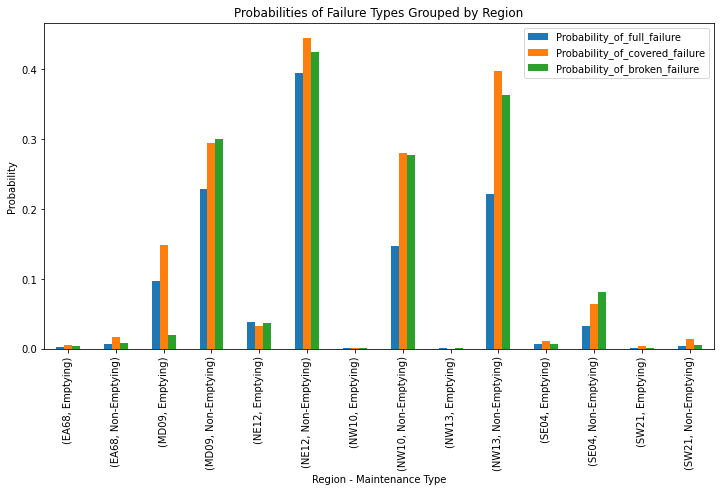

In [1229]:
# Group the data by 'Region' and 'Previous_type_of_maintenance'
grouped_data = data.groupby(['Region', 'Previous_type_of_maintenance']).sum()

# Create a grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('Region - Maintenance Type')
plt.ylabel('Probability')
plt.title('Probabilities of Failure Types Grouped by Region')

# Show the plot
plt.show()

This is due to the FIXNOW data. This is skewing the results in regions which don't do clearing of covers but they do do FIXNOW. This means that the previous type of maintenance will always be a failure. - Need to investigate

### How does region effect the probability of failure?

In [1275]:
output_dict = {"Region":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[],"Probability_of_broken_failure":[]}
for j in range(1,len(struct_data["Region"].unique())):
    q1 = bn.inference.fit(DAG_update, variables=['full_failure'], evidence={"Region":j})
    df1 = q1.df
    output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
    output_dict["Region"].append(j)
    
    q2 = bn.inference.fit(DAG_update, variables=['covered_failure'], evidence={"Region":j})
    df2 = q2.df
    output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])
    
    q2 = bn.inference.fit(DAG_update, variables=['broken_failure'], evidence={"Region":j})
    df2 = q2.df
    output_dict["Probability_of_broken_failure"].append(df2[df2["broken_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998571   |
+----+----------------+------------+
|  1 |              1 | 0.00142867 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.995611   |
+----+-------------------+------------+
|  1 |                 1 | 0.00438894 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998478   |
+----+------------------+------------+
|  1 |                1 | 0.00152242 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999375    |
+----+----------------+-------------+
|  1 |              1 | 0.000625184 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-------------+
|    |   covered_failure |           p |
+====+===================+=============+
|  0 |                 0 | 0.999319    |
+----+-------------------+-------------+
|  1 |                 1 | 0.000681475 |
+----+-------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.999277   |
+----+------------------+------------+
|  1 |                1 | 0.00072341 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999121    |
+----+----------------+-------------+
|  1 |              1 | 0.000878739 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.998987   |
+----+-------------------+------------+
|  1 |                 1 | 0.00101298 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.998793 |
+----+------------------+----------+
|  1 |                1 | 0.001207 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.995884   |
+----+----------------+------------+
|  1 |              1 | 0.00411565 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.989479  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0105207 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.994424   |
+----+------------------+------------+
|  1 |                1 | 0.00557624 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.992613   |
+----+----------------+------------+
|  1 |              1 | 0.00738697 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.986788  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0132124 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.991508   |
+----+------------------+------------+
|  1 |                1 | 0.00849229 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.890717 |
+----+----------------+----------+
|  1 |              1 | 0.109283 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.837868 |
+----+-------------------+----------+
|  1 |                 1 | 0.162132 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.953669  |
+----+------------------+-----------+
|  1 |                1 | 0.0463311 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.937883  |
+----+----------------+-----------+
|  1 |              1 | 0.0621173 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.939323  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0606773 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.93668   |
+----+------------------+-----------+
|  1 |                1 | 0.0633201 |
+----+------------------+-----------+


In [1276]:
data = pd.DataFrame(output_dict)

In [1277]:
data = data.rename(columns={"Probability_of_full_failure":"Probability of Full Failure","Probability_of_covered_failure":"Probability of Covered Failure","Probability_of_broken_failure":"Probability of Broken Failure"})

In [1278]:
data

Region  Probability of Full Failure  Probability of Covered Failure  \
0       1                     0.001429                        0.004389   
1       2                     0.000625                        0.000681   
2       3                     0.000879                        0.001013   
3       4                     0.004116                        0.010521   
4       5                     0.007387                        0.013212   
5       6                     0.109283                        0.162132   
6       7                     0.062117                        0.060677   

   Probability of Broken Failure  
0                       0.001522  
1                       0.000723  
2                       0.001207  
3                       0.005576  
4                       0.008492  
5                       0.046331  
6                       0.063320

In [1279]:
data["Region"] = data["Region"].apply(lambda x: region_mapping[x])

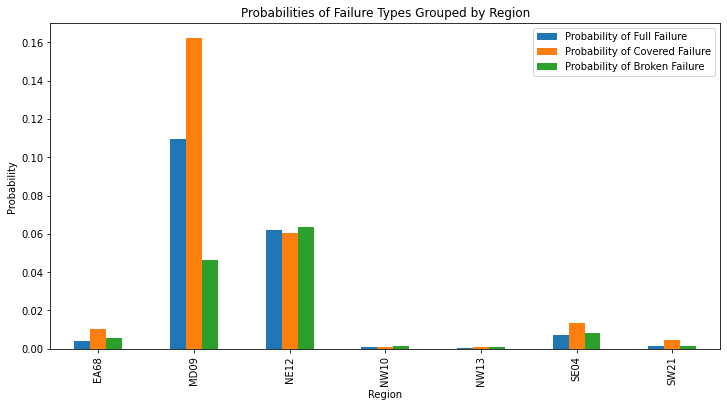

In [1280]:
# Group the data by 'Region' and 'Previous_type_of_maintenance'
grouped_data = data.groupby(['Region']).sum()

# Create a grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Probability')
plt.title('Probabilities of Failure Types Grouped by Region')

# Show the plot
plt.show()

In [1281]:
region_count = struct_data[["Region","%Full"]].groupby(["Region"],as_index=False).count()

In [1282]:
region_count

Region   %Full
0       1  141253
1       2  120936
2       3   75395
3       4   47733
4       5   24511
5       6    2117
6       7     938
7       8     177

In [1283]:
data["Region"] = data["Region"].apply(encode_region)

In [1284]:
merged_with_count = pd.merge(data,region_count,on="Region")

In [1285]:
merged_with_count = merged_with_count.rename(columns={"%Full":"Count"})

In [1286]:
total = merged_with_count["Count"].sum()

In [1287]:
merged_with_count["Probability of Full Failure Scaled"] = (merged_with_count["Probability of Full Failure"]*merged_with_count["Count"])/total
merged_with_count["Probability of Covered Failure Scaled"] = merged_with_count["Probability of Covered Failure"]*merged_with_count["Count"]/total
merged_with_count["Probability of Broken Failure Scaled"] = (merged_with_count["Probability of Broken Failure"]*merged_with_count["Count"])/total

In [1288]:
merged_with_count

Region  Probability of Full Failure  Probability of Covered Failure  \
0       1                     0.001429                        0.004389   
1       2                     0.000625                        0.000681   
2       3                     0.000879                        0.001013   
3       4                     0.004116                        0.010521   
4       5                     0.007387                        0.013212   
5       6                     0.109283                        0.162132   
6       7                     0.062117                        0.060677   

   Probability of Broken Failure   Count  Probability of Full Failure Scaled  \
0                       0.001522  141253                            0.000489   
1                       0.000723  120936                            0.000183   
2                       0.001207   75395                            0.000160   
3                       0.005576   47733                            0.000476   
4                       0.008492   24511                            0.000439   
5                       0.046331    2117                            0.000560   
6                       0.063320     938                            0.000141   

   Probability of Covered Failure Scaled  Probability of Broken Failure Scaled  
0                               0.001502                              0.000521  
1                               0.000200                              0.000212  
2                               0.000185                              0.000220  
3                               0.001216                              0.000645  
4                               0.000784                              0.000504  
5                               0.000831                              0.000238  
6                               0.000138                              0.000144

In [1290]:
data = merged_with_count[["Region","Probability of Full Failure Scaled","Probability of Covered Failure Scaled","Probability of Broken Failure Scaled"]]

In [1291]:
data["Region"] = data["Region"].apply(lambda x: region_mapping[x])

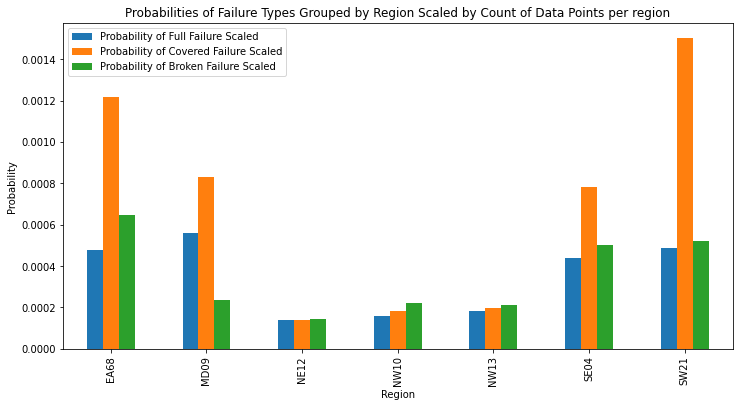

In [1292]:
# Group the data by 'Region' and 'Previous_type_of_maintenance'
grouped_data = data.groupby(['Region']).sum()

# Create a grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Probability')
plt.title('Probabilities of Failure Types Grouped by Region Scaled by Count of Data Points per region')

# Show the plot
plt.show()

## Repeat for truth DAG - Compare Differences

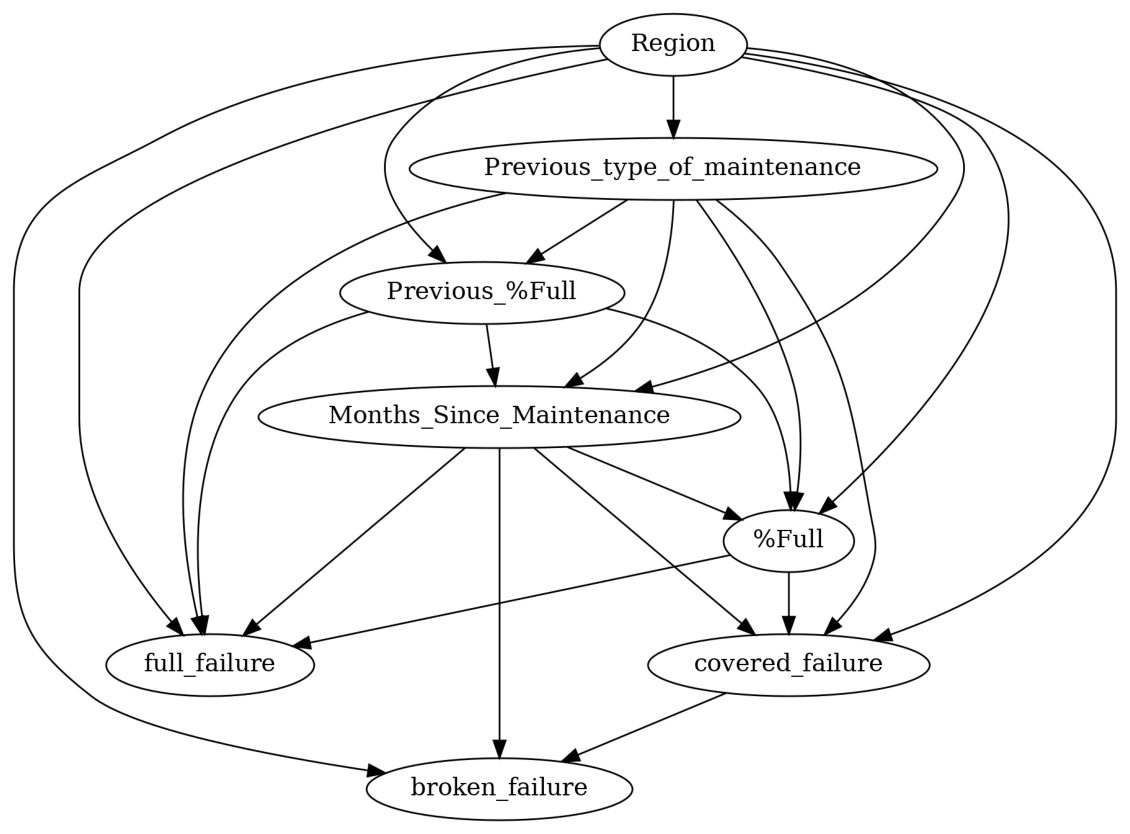

In [1296]:
# visualization using pydot
pyd = GraphUtils.to_pydot(truth_dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('human_intuition.png')

In [1298]:
#mapping = {'X1':'%Full',
# 'X2':'Region',
# 'X3':'full_failure',
# 'X4':'covered_failure',
# 'X5':'broken_failure',
# 'X6':'Previous_%Full',
# 'X7':'Previous_type_of_maintenance',
# 'X8':'Months_Since_Maintenance'}
# The below code extracts the edges from a dag so that a bnlearn dag structure can be  created
edges = []
for edge in truth_dag.get_graph_edges():
    edges.append((edge.get_node1().get_name(),edge.get_node2().get_name()))


In [1299]:
edges

[('Region', '%Full'),
 ('%Full', 'full_failure'),
 ('%Full', 'covered_failure'),
 ('Previous_%Full', '%Full'),
 ('Previous_type_of_maintenance', '%Full'),
 ('Months_Since_Maintenance', '%Full'),
 ('Region', 'full_failure'),
 ('Region', 'covered_failure'),
 ('Region', 'broken_failure'),
 ('Region', 'Previous_%Full'),
 ('Region', 'Previous_type_of_maintenance'),
 ('Region', 'Months_Since_Maintenance'),
 ('Previous_%Full', 'full_failure'),
 ('Previous_type_of_maintenance', 'full_failure'),
 ('Months_Since_Maintenance', 'full_failure'),
 ('covered_failure', 'broken_failure'),
 ('Previous_type_of_maintenance', 'covered_failure'),
 ('Months_Since_Maintenance', 'covered_failure'),
 ('Months_Since_Maintenance', 'broken_failure'),
 ('Previous_type_of_maintenance', 'Previous_%Full'),
 ('Previous_%Full', 'Months_Since_Maintenance'),
 ('Previous_type_of_maintenance', 'Months_Since_Maintenance')]

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


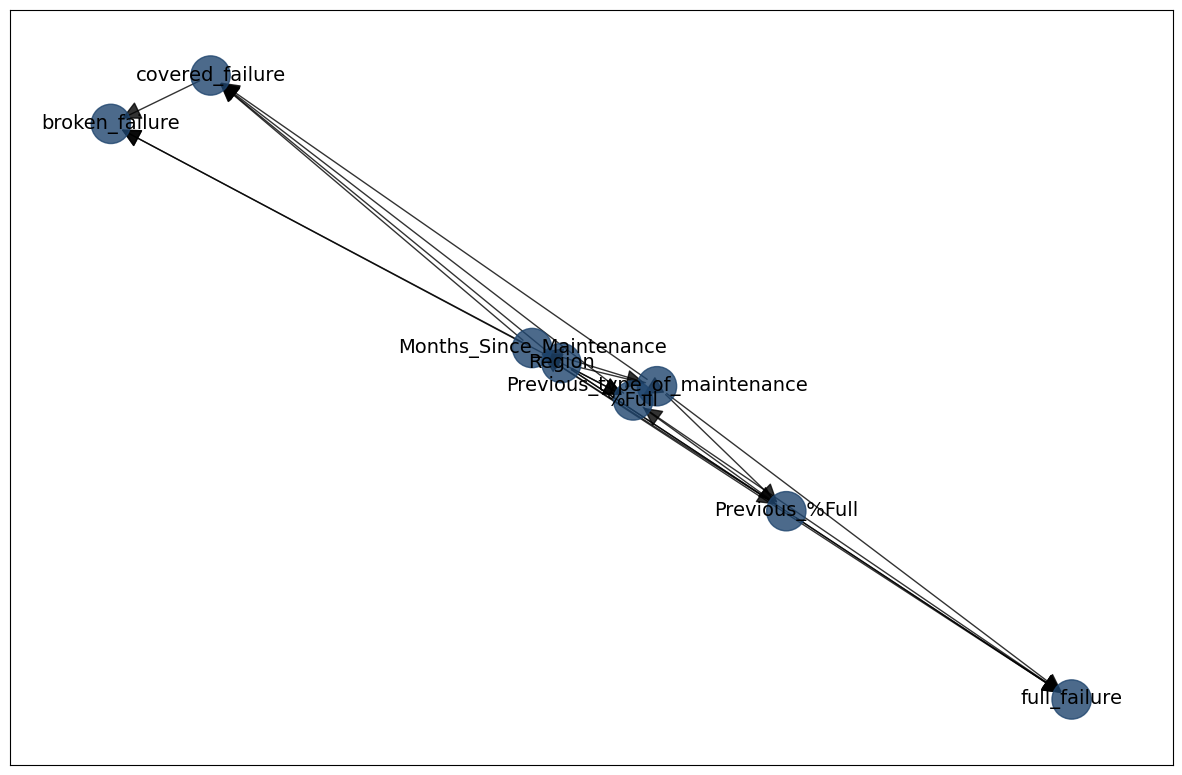

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Region:
+-----------+-------------+
| Region(1) | 0.341443    |
+-----------+-------------+
| Region(2) | 0.292376    |
+-----------+-------------+
| Region(3) | 0.182389    |
+-----------+-------------+
| Region(4) | 0.115582    |
+-----------+-------------+
| Region(5) | 0.0594986   |
+-----------+-------------+
| Region(6) | 0.00541467  |
+-----------+-------------+
| Region(7) | 0.00256726  |
+-----------+-------------+
| Region(8) | 0.000729363 |
+-----------+-------------+
[bnlearn] >CPD of %Full:
+------------------------------+-----+---------------------------------+
| Months_Since_Maintenance     | ... | Months_Since_Maintenance(8)     |
+------------------------------+-----+---------------------------------+
| Previous_%Full               | ... | Previous_%Full(4)               |
+------------------------------+-----+---------------------------------+
| Previous_type_of_maintenance | ... | Pre

In [1304]:
#edges = [('A', 'B'), ('A', 'C'), ('A', 'D')]
# Create DAG and store in model
model = bn.make_DAG(edges)
bn.plot(model)
truth_bn = bn.parameter_learning.fit(model, struct_data)

### Does the time to mainetnance effect failure rates? - Truth DAG

In [1308]:
output_dict = {"Months":[],"Probability_of_broken_failure":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[]}
for i in range(0,9):
    q1 = bn.inference.fit(truth_bn, variables=['broken_failure'], evidence={"Months_Since_Maintenance":i})
    df1 = q1.df
    output_dict["Probability_of_broken_failure"].append(df1[df1["broken_failure"]==1]["p"][1])

    q2 = bn.inference.fit(truth_bn, variables=['full_failure'], evidence={"Months_Since_Maintenance":i})
    df2 = q2.df
    output_dict["Probability_of_full_failure"].append(df2[df2["full_failure"]==1]["p"][1])

    q3 = bn.inference.fit(truth_bn, variables=['covered_failure'], evidence={"Months_Since_Maintenance":i})
    df3 = q3.df
    output_dict["Probability_of_covered_failure"].append(df3[df3["covered_failure"]==1]["p"][1])
    
    output_dict["Months"].append(months_mapping[i])

[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.992872   |
+----+------------------+------------+
|  1 |                1 | 0.00712788 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.991537   |
+----+----------------+------------+
|  1 |              1 | 0.00846335 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.985005 |
+----+-------------------+----------+
|  1 |                 1 | 0.014995 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.997594   |
+----+------------------+------------+
|  1 |                1 | 0.00240551 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997855   |
+----+----------------+------------+
|  1 |              1 | 0.00214483 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.994271   |
+----+-------------------+------------+
|  1 |                 1 | 0.00572919 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998323   |
+----+------------------+------------+
|  1 |                1 | 0.00167662 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998345   |
+----+----------------+------------+
|  1 |              1 | 0.00165479 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996063   |
+----+-------------------+------------+
|  1 |                 1 | 0.00393679 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998454   |
+----+------------------+------------+
|  1 |                1 | 0.00154577 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.998646  |
+----+----------------+-----------+
|  1 |              1 | 0.0013535 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.997589   |
+----+-------------------+------------+
|  1 |                 1 | 0.00241098 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998728   |
+----+------------------+------------+
|  1 |                1 | 0.00127242 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998868   |
+----+----------------+------------+
|  1 |              1 | 0.00113191 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.997828  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0021717 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.997315   |
+----+------------------+------------+
|  1 |                1 | 0.00268478 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997551   |
+----+----------------+------------+
|  1 |              1 | 0.00244854 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996067   |
+----+-------------------+------------+
|  1 |                 1 | 0.00393342 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.995027   |
+----+------------------+------------+
|  1 |                1 | 0.00497342 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.995181   |
+----+----------------+------------+
|  1 |              1 | 0.00481934 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.993409   |
+----+-------------------+------------+
|  1 |                 1 | 0.00659128 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.993366   |
+----+------------------+------------+
|  1 |                1 | 0.00663443 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.991038   |
+----+----------------+------------+
|  1 |              1 | 0.00896211 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.989317  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0106826 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.992269   |
+----+------------------+------------+
|  1 |                1 | 0.00773139 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.992763   |
+----+----------------+------------+
|  1 |              1 | 0.00723702 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.992021   |
+----+-------------------+------------+
|  1 |                 1 | 0.00797858 |
+----+-------------------+------------+


Text(0.5, 1.0, 'Plot of Probability of Failure vs Time for the three Failure Modes')

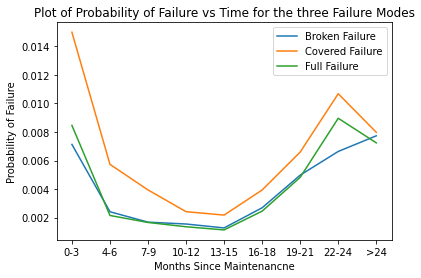

In [1309]:
output = pd.DataFrame(output_dict)
plt.plot(output["Months"],output["Probability_of_broken_failure"],label='Broken Failure')
plt.plot(output["Months"],output["Probability_of_covered_failure"],label='Covered Failure')
plt.plot(output["Months"],output["Probability_of_full_failure"],label='Full Failure')
plt.legend()
plt.xlabel("Months Since Maintenancne")
plt.ylabel("Probability of Failure")
plt.title("Plot of Probability of Failure vs Time for the three Failure Modes")

In [1310]:
one_year = ["0-3","4-6","7-9","10-12"]
two_years = ["0-3","4-6","7-9","10-12","13-15","16-18","19-21","22-24"]
full_failure_within_one_year = output[output["Months"].isin(one_year)]["Probability_of_full_failure"].sum()
covered_failure_within_one_year = output[output["Months"].isin(one_year)]["Probability_of_covered_failure"].sum()
full_failure_within_two_years = output[output["Months"].isin(two_years)]["Probability_of_full_failure"].sum() 
covered_failure_within_two_years = output[output["Months"].isin(two_years)]["Probability_of_covered_failure"].sum()

In [1311]:
failure_within_one_year_broken = output[output["Months"].isin(one_year)]["Probability_of_broken_failure"].sum()
failure_within_two_years_broken = output[output["Months"].isin(two_years)]["Probability_of_broken_failure"].sum()

In [1312]:
print(f"Probability of at least one full failure within one year: {full_failure_within_one_year}")
print(f"Probability of at least one covered failure within one year: {covered_failure_within_one_year}")
print(f"Probability of at least one broken failure within one year: {failure_within_one_year_broken}")

Probability of at least one full failure within one year: 0.013616467608998841
Probability of at least one covered failure within one year: 0.027071955326333778
Probability of at least one broken failure within one year: 0.012755787325698834


In [1313]:
full_failure_within_one_year+covered_failure_within_one_year+failure_within_one_year_broken

0.05344421026103145

In [1314]:
print(f"Probability of at least one full failure within two years: {full_failure_within_two_years}")
print(f"Probability of at least one covered failure within two years: {covered_failure_within_two_years}")
print(f"Probability of at least one broken failure within two years: {failure_within_two_years_broken}")

Probability of at least one full failure within two years: 0.030978361765727422
Probability of at least one covered failure within two years: 0.0504509126452766
Probability of at least one broken failure within two years: 0.02832083250363321


In [1315]:
full_failure_within_two_years+covered_failure_within_two_years+failure_within_two_years_broken

0.10975010691463723

### Is previous percentage full predictive of future percentage full?

In [1316]:
output_dict = {"Previous_%Full":[],"%Full_Predicted":[],"Probability_of_%Full":[]}
for i in range(0,5):
    q1 = bn.inference.fit(truth_bn, variables=['%Full'], evidence={"Previous_%Full":i})
    df1 = q1.df
    for index, row in df1.iterrows():
        output_dict["Probability_of_%Full"].append(row["p"])
        output_dict["Previous_%Full"].append(i)
        output_dict["%Full_Predicted"].append(row["%Full"])

[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0861406 |
+----+---------+-----------+
|  1 |       1 | 0.355183  |
+----+---------+-----------+
|  2 |       2 | 0.335046  |
+----+---------+-----------+
|  3 |       3 | 0.114499  |
+----+---------+-----------+
|  4 |       4 | 0.109132  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0716755 |
+----+---------+-----------+
|  1 |       1 | 0.321302  |
+----+---------+-----------+
|  2 |       2 | 0.30962   |
+----+---------+-----------+
|  3 |       3 | 0.168868  |
+----+---------+-----------+
|  4 |       4 | 0.128534  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0602786 |
+----+---------+-----------+
|  1 |       1 | 0.262514  |
+----+---------+-----------+
|  2 |       2 | 0.351597  |
+----+---------+-----------+
|  3 |       3 | 0.221514  |
+----+---------+-----------+
|  4 |       4 | 0.104096  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+-----------+
|    |   %Full |         p |
+====+=========+===========+
|  0 |       0 | 0.0461394 |
+----+---------+-----------+
|  1 |       1 | 0.221315  |
+----+---------+-----------+
|  2 |       2 | 0.351584  |
+----+---------+-----------+
|  3 |       3 | 0.255887  |
+----+---------+-----------+
|  4 |       4 | 0.125075  |
+----+---------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+---------+----------+
|    |   %Full |        p |
+====+=========+==========+
|  0 |       0 | 0.044996 |
+----+---------+----------+
|  1 |       1 | 0.261194 |
+----+---------+----------+
|  2 |       2 | 0.31681  |
+----+---------+----------+
|  3 |       3 | 0.20804  |
+----+---------+----------+
|  4 |       4 | 0.16896  |
+----+---------+----------+


In [1323]:
data = pd.DataFrame(output_dict)

In [1324]:
data["%Full_Predicted"] = data["%Full_Predicted"].astype(int)

In [1325]:
param_dict = {
        0:"0%",
        1:"0-25%",
        2:"25-50%",
        3:"50-75%",
        4:"75-100%"
    }
data["Previous_%Full"] = data["Previous_%Full"].apply(lambda x: param_dict[x])

In [1326]:
data["%Full_Predicted"] = data["%Full_Predicted"].apply(lambda x: param_dict[x])

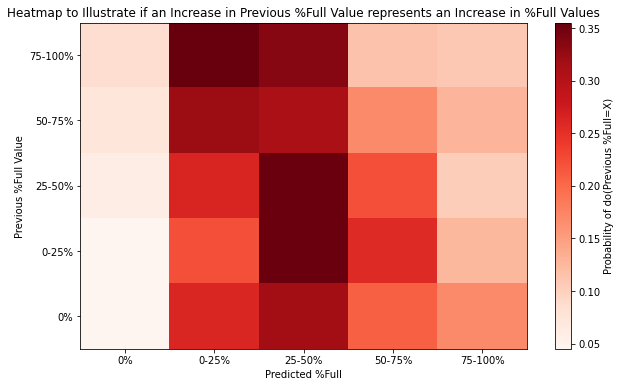

In [1327]:
# Pivot the DataFrame to prepare for heatmap
heatmap_data = data.pivot(index='Previous_%Full', columns='%Full_Predicted', values='Probability_of_%Full')

# Create the heatmap
plt.figure(figsize=(10, 6))  # Set the figure size
plt.imshow(heatmap_data, cmap='Reds', interpolation='nearest', aspect='auto')

# Add a colorbar to indicate the probability values
plt.colorbar(label='Probability of do(Previous %Full=X)')

# Set the x and y tick labels
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index[::-1])  # Reverse the True Label axis

# Add labels and title
plt.xlabel('Predicted %Full')
plt.ylabel('Previous %Full Value')
plt.title('Heatmap to Illustrate if an Increase in Previous %Full Value represents an Increase in %Full Values')

# Show the plot
plt.show()

### Does previous percentage full influence covered and full failures?

In [1330]:
output_dict = {"Previous_%Full":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[]}
for i in range(0,5):
    q1 = bn.inference.fit(truth_bn, variables=['full_failure'], evidence={"Previous_%Full":i})
    df1 = q1.df
    output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
    output_dict["Previous_%Full"].append(i)
    q2 = bn.inference.fit(truth_bn, variables=['covered_failure'], evidence={"Previous_%Full":i})
    df2 = q2.df
    output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.994443   |
+----+----------------+------------+
|  1 |              1 | 0.00555746 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.990479   |
+----+-------------------+------------+
|  1 |                 1 | 0.00952051 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997847   |
+----+----------------+------------+
|  1 |              1 | 0.00215323 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.994795   |
+----+-------------------+------------+
|  1 |                 1 | 0.00520508 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998325   |
+----+----------------+------------+
|  1 |              1 | 0.00167542 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.995562   |
+----+-------------------+------------+
|  1 |                 1 | 0.00443821 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997933   |
+----+----------------+------------+
|  1 |              1 | 0.00206713 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.99647    |
+----+-------------------+------------+
|  1 |                 1 | 0.00353049 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.993863   |
+----+----------------+------------+
|  1 |              1 | 0.00613666 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.993277   |
+----+-------------------+------------+
|  1 |                 1 | 0.00672283 |
+----+-------------------+------------+


In [1331]:
data = pd.DataFrame(output_dict)

In [1332]:
data["Previous_%Full"] = data["Previous_%Full"].apply(lambda x: param_dict[x])

Text(0.5, 1.0, 'Plot of Probability of Failure vs Previous Percentage Full for two Failure Modes')

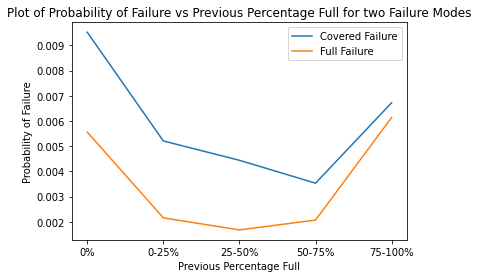

In [1333]:
plt.plot(data["Previous_%Full"],data["Probability_of_covered_failure"],label='Covered Failure')
plt.plot(data["Previous_%Full"],data["Probability_of_full_failure"],label='Full Failure')
plt.legend()
plt.xlabel("Previous Percentage Full")
plt.ylabel("Probability of Failure")
plt.title("Plot of Probability of Failure vs Previous Percentage Full for two Failure Modes")

### Does the type of maintenance effect the probability of failure? What is this effect across regions?

In [1334]:
output_dict = {"Region":[],"Previous_type_of_maintenance":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[],"Probability_of_broken_failure":[]}
for j in range(1,len(struct_data["Region"].unique())):
    for i in range(0,2):
        q1 = bn.inference.fit(truth_bn, variables=['full_failure'], evidence={"Previous_type_of_maintenance":i,"Region":j})
        df1 = q1.df
        output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
        output_dict["Previous_type_of_maintenance"].append(i)
        output_dict["Region"].append(j)
        q2 = bn.inference.fit(truth_bn, variables=['covered_failure'], evidence={"Previous_type_of_maintenance":i,"Region":j})
        df2 = q2.df
        output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])
        
        q2 = bn.inference.fit(truth_bn, variables=['broken_failure'], evidence={"Previous_type_of_maintenance":i,"Region":j})
        df2 = q2.df
        output_dict["Probability_of_broken_failure"].append(df2[df2["broken_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.993054   |
+----+----------------+------------+
|  1 |              1 | 0.00694557 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.985271  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0147289 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.997087   |
+----+------------------+------------+
|  1 |                1 | 0.00291267 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998893   |
+----+----------------+------------+
|  1 |              1 | 0.00110689 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.996335   |
+----+-------------------+------------+
|  1 |                 1 | 0.00366502 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998588   |
+----+------------------+------------+
|  1 |                1 | 0.00141194 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.601911 |
+----+----------------+----------+
|  1 |              1 | 0.398089 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.601911 |
+----+-------------------+----------+
|  1 |                 1 | 0.398089 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.806721 |
+----+------------------+----------+
|  1 |                1 | 0.193279 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999659    |
+----+----------------+-------------+
|  1 |              1 | 0.000340958 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-------------+
|    |   covered_failure |           p |
+====+===================+=============+
|  0 |                 0 | 0.999576    |
+----+-------------------+-------------+
|  1 |                 1 | 0.000423615 |
+----+-------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-------------+
|    |   broken_failure |           p |
+====+==================+=============+
|  0 |                0 | 0.999427    |
+----+------------------+-------------+
|  1 |                1 | 0.000573038 |
+----+------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.719731 |
+----+----------------+----------+
|  1 |              1 | 0.280269 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.719731 |
+----+-------------------+----------+
|  1 |                 1 | 0.280269 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.862618 |
+----+------------------+----------+
|  1 |                1 | 0.137382 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999533    |
+----+----------------+-------------+
|  1 |              1 | 0.000467454 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-------------+
|    |   covered_failure |           p |
+====+===================+=============+
|  0 |                 0 | 0.9994      |
+----+-------------------+-------------+
|  1 |                 1 | 0.000600065 |
+----+-------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.999056   |
+----+------------------+------------+
|  1 |                1 | 0.00094395 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.992708   |
+----+----------------+------------+
|  1 |              1 | 0.00729186 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.982634 |
+----+-------------------+----------+
|  1 |                 1 | 0.017366 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.992247   |
+----+------------------+------------+
|  1 |                1 | 0.00775346 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.997188   |
+----+----------------+------------+
|  1 |              1 | 0.00281156 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.99397    |
+----+-------------------+------------+
|  1 |                 1 | 0.00602972 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.995311   |
+----+------------------+------------+
|  1 |                1 | 0.00468877 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.937457  |
+----+----------------+-----------+
|  1 |              1 | 0.0625432 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.936075  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0639254 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.974279  |
+----+------------------+-----------+
|  1 |                1 | 0.0257208 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.994009   |
+----+----------------+------------+
|  1 |              1 | 0.00599059 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.988322 |
+----+-------------------+----------+
|  1 |                 1 | 0.011678 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.992143   |
+----+------------------+------------+
|  1 |                1 | 0.00785744 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.757683 |
+----+----------------+----------+
|  1 |              1 | 0.242317 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.705674 |
+----+-------------------+----------+
|  1 |                 1 | 0.294326 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.878627 |
+----+------------------+----------+
|  1 |                1 | 0.121373 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.906796  |
+----+----------------+-----------+
|  1 |              1 | 0.0932036 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.851638 |
+----+-------------------+----------+
|  1 |                 1 | 0.148362 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.96364   |
+----+------------------+-----------+
|  1 |                1 | 0.0363603 |
+----+------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+----------+
|    |   full_failure |        p |
+====+================+==========+
|  0 |              0 | 0.568966 |
+----+----------------+----------+
|  1 |              1 | 0.431034 |
+----+----------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.555172 |
+----+-------------------+----------+
|  1 |                 1 | 0.444828 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+----------+
|    |   broken_failure |        p |
+====+==================+==========+
|  0 |                0 | 0.679049 |
+----+------------------+----------+
|  1 |                1 | 0.320951 |
+----+------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.967441  |
+----+----------------+-----------+
|  1 |              1 | 0.0325593 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.967441  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0325593 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.957364  |
+----+------------------+-----------+
|  1 |                1 | 0.0426361 |
+----+------------------+-----------+


In [1335]:
data = pd.DataFrame(output_dict)

In [1336]:
data = merged.drop(columns={"Count"})

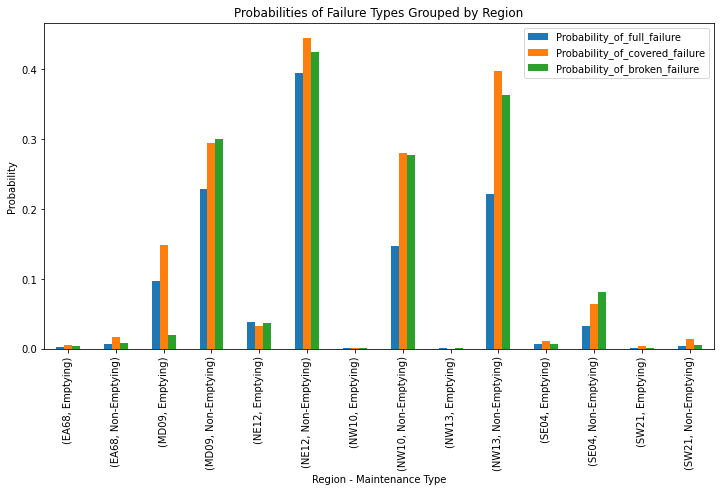

In [1337]:
# Group the data by 'Region' and 'Previous_type_of_maintenance'
grouped_data = data.groupby(['Region', 'Previous_type_of_maintenance']).sum()

# Create a grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('Region - Maintenance Type')
plt.ylabel('Probability')
plt.title('Probabilities of Failure Types Grouped by Region')

# Show the plot
plt.show()

### How does region effect the probability of failiure

In [1348]:
output_dict = {"Region":[],"Probability_of_full_failure":[],"Probability_of_covered_failure":[],"Probability_of_broken_failure":[]}
for j in range(1,len(struct_data["Region"].unique())):
    q1 = bn.inference.fit(truth_bn, variables=['full_failure'], evidence={"Region":j})
    df1 = q1.df
    output_dict["Probability_of_full_failure"].append(df1[df1["full_failure"]==1]["p"][1])
    output_dict["Region"].append(j)
    
    q2 = bn.inference.fit(truth_bn, variables=['covered_failure'], evidence={"Region":j})
    df2 = q2.df
    output_dict["Probability_of_covered_failure"].append(df2[df2["covered_failure"]==1]["p"][1])
    
    q2 = bn.inference.fit(truth_bn, variables=['broken_failure'], evidence={"Region":j})
    df2 = q2.df
    output_dict["Probability_of_broken_failure"].append(df2[df2["broken_failure"]==1]["p"][1])

[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.998511   |
+----+----------------+------------+
|  1 |              1 | 0.00148892 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.995611   |
+----+-------------------+------------+
|  1 |                 1 | 0.00438894 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.99849    |
+----+------------------+------------+
|  1 |                1 | 0.00151014 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999401    |
+----+----------------+-------------+
|  1 |              1 | 0.000598872 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-------------+
|    |   covered_failure |           p |
+====+===================+=============+
|  0 |                 0 | 0.999319    |
+----+-------------------+-------------+
|  1 |                 1 | 0.000681475 |
+----+-------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-------------+
|    |   broken_failure |           p |
+====+==================+=============+
|  0 |                0 | 0.999302    |
+----+------------------+-------------+
|  1 |                1 | 0.000697995 |
+----+------------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------+
|    |   full_failure |           p |
+====+================+=============+
|  0 |              0 | 0.999119    |
+----+----------------+-------------+
|  1 |              1 | 0.000880561 |
+----+----------------+-------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+------------+
|    |   covered_failure |          p |
+====+===================+============+
|  0 |                 0 | 0.998987   |
+----+-------------------+------------+
|  1 |                 1 | 0.00101298 |
+----+-------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.998855   |
+----+------------------+------------+
|  1 |                1 | 0.00114539 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+------------+
|    |   full_failure |          p |
+====+================+============+
|  0 |              0 | 0.995414   |
+----+----------------+------------+
|  1 |              1 | 0.00458649 |
+----+----------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.989479  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0105207 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.994097   |
+----+------------------+------------+
|  1 |                1 | 0.00590288 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.992349  |
+----+----------------+-----------+
|  1 |              1 | 0.0076514 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.986788  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0132124 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+------------+
|    |   broken_failure |          p |
+====+==================+============+
|  0 |                0 | 0.991618   |
+----+------------------+------------+
|  1 |                1 | 0.00838204 |
+----+------------------+------------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+---------+
|    |   full_failure |       p |
+====+================+=========+
|  0 |              0 | 0.89273 |
+----+----------------+---------+
|  1 |              1 | 0.10727 |
+----+----------------+---------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+----------+
|    |   covered_failure |        p |
+====+===================+==========+
|  0 |                 0 | 0.837868 |
+----+-------------------+----------+
|  1 |                 1 | 0.162132 |
+----+-------------------+----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+---------+
|    |   broken_failure |       p |
+====+==================+=========+
|  0 |                0 | 0.95562 |
+----+------------------+---------+
|  1 |                1 | 0.04438 |
+----+------------------+---------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    |   full_failure |         p |
+====+================+===========+
|  0 |              0 | 0.940263  |
+----+----------------+-----------+
|  1 |              1 | 0.0597366 |
+----+----------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+-------------------+-----------+
|    |   covered_failure |         p |
+====+===================+===========+
|  0 |                 0 | 0.939323  |
+----+-------------------+-----------+
|  1 |                 1 | 0.0606773 |
+----+-------------------+-----------+
[bnlearn] >Variable Elimination..


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+------------------+-----------+
|    |   broken_failure |         p |
+====+==================+===========+
|  0 |                0 | 0.938382  |
+----+------------------+-----------+
|  1 |                1 | 0.0616181 |
+----+------------------+-----------+


In [1349]:
data = pd.DataFrame(output_dict)

In [1350]:
data = data.rename(columns={"Probability_of_full_failure":"Probability of Full Failure","Probability_of_covered_failure":"Probability of Covered Failure","Probability_of_broken_failure":"Probability of Broken Failure"})

In [1351]:
data["Region"] = data["Region"].apply(lambda x: region_mapping[x])

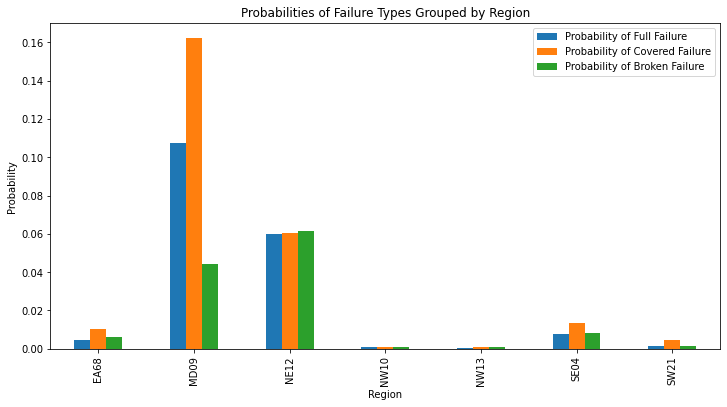

In [1352]:
# Group the data by 'Region' and 'Previous_type_of_maintenance'
grouped_data = data.groupby(['Region']).sum()

# Create a grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Probability')
plt.title('Probabilities of Failure Types Grouped by Region')

# Show the plot
plt.show()

In [1347]:
data["Region"] = data["Region"].apply(lambda x: region_mapping[x])

KeyError: 'SW21'

In [1281]:
region_count = struct_data[["Region","%Full"]].groupby(["Region"],as_index=False).count()

In [1282]:
region_count

Region   %Full
0       1  141253
1       2  120936
2       3   75395
3       4   47733
4       5   24511
5       6    2117
6       7     938
7       8     177

In [1283]:
data["Region"] = data["Region"].apply(encode_region)

In [1284]:
merged_with_count = pd.merge(data,region_count,on="Region")

In [1285]:
merged_with_count = merged_with_count.rename(columns={"%Full":"Count"})

In [1286]:
total = merged_with_count["Count"].sum()

In [1287]:
merged_with_count["Probability of Full Failure Scaled"] = (merged_with_count["Probability of Full Failure"]*merged_with_count["Count"])/total
merged_with_count["Probability of Covered Failure Scaled"] = merged_with_count["Probability of Covered Failure"]*merged_with_count["Count"]/total
merged_with_count["Probability of Broken Failure Scaled"] = (merged_with_count["Probability of Broken Failure"]*merged_with_count["Count"])/total

In [1288]:
merged_with_count

Region  Probability of Full Failure  Probability of Covered Failure  \
0       1                     0.001429                        0.004389   
1       2                     0.000625                        0.000681   
2       3                     0.000879                        0.001013   
3       4                     0.004116                        0.010521   
4       5                     0.007387                        0.013212   
5       6                     0.109283                        0.162132   
6       7                     0.062117                        0.060677   

   Probability of Broken Failure   Count  Probability of Full Failure Scaled  \
0                       0.001522  141253                            0.000489   
1                       0.000723  120936                            0.000183   
2                       0.001207   75395                            0.000160   
3                       0.005576   47733                            0.000476   
4                       0.008492   24511                            0.000439   
5                       0.046331    2117                            0.000560   
6                       0.063320     938                            0.000141   

   Probability of Covered Failure Scaled  Probability of Broken Failure Scaled  
0                               0.001502                              0.000521  
1                               0.000200                              0.000212  
2                               0.000185                              0.000220  
3                               0.001216                              0.000645  
4                               0.000784                              0.000504  
5                               0.000831                              0.000238  
6                               0.000138                              0.000144

In [1290]:
data = merged_with_count[["Region","Probability of Full Failure Scaled","Probability of Covered Failure Scaled","Probability of Broken Failure Scaled"]]

In [1291]:
data["Region"] = data["Region"].apply(lambda x: region_mapping[x])

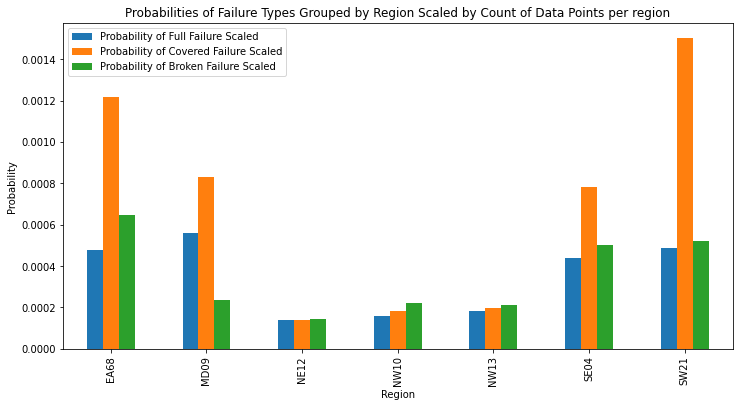

In [1292]:
# Group the data by 'Region' and 'Previous_type_of_maintenance'
grouped_data = data.groupby(['Region']).sum()

# Create a grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Probability')
plt.title('Probabilities of Failure Types Grouped by Region Scaled by Count of Data Points per region')

# Show the plot
plt.show()